# XPCS&XSVS Pipeline for Single-(Gi)-SAXS Run
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

### DEV
* V8: Update visbility error bar calculation using pi = his/N +/- sqrt(his_i)/N
*     Update normlization in g2 calculation uing 2D-savitzky golay (SG ) smooth

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [2]:
from pyCHX.chx_packages import *
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams.update({ 'image.origin': 'lower'   })
plt.rcParams.update({ 'image.interpolation': 'none'   })
import pickle as cpk
from pyCHX.chx_xpcs_xsvs_jupyter_V1 import *
import itertools
#from pyCHX.XPCS_SAXS import get_QrQw_From_RoiMask

from pyCHX.chx_generic_functions import plot_q_rate_general,plot_q_g2fitpara_general

In [3]:
#%run /home/yuzhang/pyCHX_link/pyCHX/chx_generic_functions.py

In [4]:
#%matplotlib notebook
%matplotlib inline

## Control Runs Here

In [5]:
#scat_geometry = 'saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
#scat_geometry = 'ang_saxs' 
#scat_geometry = 'gi_waxs' 
scat_geometry = 'gi_saxs'

analysis_type_auto = True #if True, will take "analysis type" option from data acquisition func series
qphi_analysis = False  #if True, will do q-phi (anisotropic analysis for transmission saxs)

isotropic_Q_mask = 'normal' #'wide' # 'normal' # 'wide'  ## select wich Q-mask to use for rings: 'normal' or 'wide'
phi_Q_mask = 'phi_4x_20deg'   ## select wich Q-mask to use for phi analysis
q_mask_name = ''

force_compress = False #True   #force to compress data 
bin_frame = False   #generally make bin_frame as False
para_compress = True    #parallel compress
run_fit_form = False    #run fit form factor 
run_waterfall =  True   #run waterfall analysis
run_profile_plot = False  #run prolfile plot for gi-saxs
run_t_ROI_Inten = True  #run  ROI intensity as a function of time
run_get_mass_center = False  # Analysis for mass center of reflective beam center
run_invariant_analysis = False
run_one_time =  True  #run  one-time
cal_g2_error =  False  #True  #calculate g2 signal to noise
#run_fit_g2 = True       #run  fit one-time, the default function is "stretched exponential"
fit_g2_func = 'stretched'
run_two_time =   True    #run  two-time
run_four_time = False #True #True #False   #run  four-time
run_xsvs=  False #False         #run visibility analysis
att_pdf_report = True    #attach the pdf report to CHX olog
qth_interest = 1 #the intested single qth             
use_sqnorm = True    #if True, use sq to normalize intensity
use_SG = True # False        #if True, use the Sawitzky-Golay filter for <I(pix)>
use_imgsum_norm= True  #if True use imgsum to normalize intensity for one-time calculatoin
pdf_version='_%s'%get_today_date()     #for pdf report name
run_dose =  False #True # True #False  #run dose_depend analysis


if scat_geometry == 'gi_saxs':run_xsvs= False;use_sqnorm=False
if scat_geometry == 'gi_waxs':use_sqnorm = False
if scat_geometry != 'saxs':qphi_analysis = False;scat_geometry_ = scat_geometry  
else:scat_geometry_ = ['','ang_'][qphi_analysis]+ scat_geometry   
if scat_geometry != 'gi_saxs':run_profile_plot = False

In [6]:
scat_geometry

'gi_saxs'

In [7]:
taus=None;g2=None;tausb=None;g2b=None;g12b=None;taus4=None;g4=None;times_xsv=None;contrast_factorL=None; lag_steps = None 

## Make a directory for saving results

In [8]:
CYCLE= '2019_1'  #change clycle here
path = '/XF11ID/analysis/%s/masks/'%CYCLE

## Load Metadata & Image Data



### Change this line to give a uid

In [9]:
#username      =  getpass.getuser()
uid = '262b7d1-61f7-44db-b961-217f27c0b2a0'
username = 'pmyint'
run_two_time  =   True 
run_dose      =   False 



In [10]:
# Parameters
uid = "f8ef1c87-9663-4540-b12c-e15581aa4df8"
username = "pmyint"
run_two_time = True
run_dose = False


In [11]:
data_dir0  = create_user_folder(CYCLE, username)
print( data_dir0 )

Results from this analysis will be stashed in the directory /XF11ID/analysis/2019_1/pmyint/Results/
/XF11ID/analysis/2019_1/pmyint/Results/


In [12]:
uid = uid[:8]
print('The current uid for analysis is: %s...'%uid)

The current uid for analysis is: f8ef1c87...


In [13]:
#get_last_uids( -1)

In [14]:
sud = get_sid_filenames(db[uid])
for pa in sud[2]:
    if 'master.h5' in pa:
        data_fullpath = pa
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], data_fullpath ))

#start_time, stop_time = '2017-2-24  12:23:00', '2017-2-24  13:42:00' 
#sids, uids, fuids  = find_uids(start_time, stop_time)

filepath : /nsls2/xf11id1/data/2019/03/31/6e6c3b44-5251-40a5-a367
got images_per_file
scan_id, full-uid, data path are:  7422--f8ef1c87-9663-4540-b12c-e15581aa4df8--/nsls2/xf11id1/data/2019/03/31/6e6c3b44-5251-40a5-a367_25553_master.h5


In [15]:
data_dir = os.path.join(data_dir0, '%s/'%(sud[1]))
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)
uidstr = 'uid=%s'%uid

Results from this analysis will be stashed in the directory /XF11ID/analysis/2019_1/pmyint/Results/f8ef1c87-9663-4540-b12c-e15581aa4df8/


# Don't Change the lines below here

* get metadata

In [16]:
md = get_meta_data( uid )
md_blue = md.copy()
#md_blue

More than one device. This would have unintented consequences.Currently, only the device contains 'default_dec=eiger'.


In [17]:
#md_blue['detectors'][0]
#if md_blue['OAV_mode'] != 'none':
#    cx , cy = md_blue[md_blue['detectors'][0]+'_beam_center_x'], md_blue[md_blue['detectors'][0]+'_beam_center_x']
#else: 
#    cx , cy = md_blue['beam_center_x'], md_blue['beam_center_y']
#print(cx,cy)

In [18]:
detectors = sorted(get_detectors(db[uid]))
print('The detectors are:%s'%detectors)
if len(detectors) >1:
    md['detector'] = detectors[1]
    print( md['detector'])


The detectors are:['eiger4m_single_image']


In [19]:
if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
    reverse= True
    rot90= False
elif md['detector'] =='eiger500K_single_image':    
    reverse= True
    rot90=True
elif md['detector'] =='eiger1m_single_image':    
    reverse= True
    rot90=False
print('Image reverse: %s\nImage rotate 90: %s'%(reverse, rot90))    

Image reverse: True
Image rotate 90: False


In [20]:
try:
    cx , cy = md_blue['beam_center_x'], md_blue['beam_center_y']
    print(cx,cy)
except:
    print('Will find cx,cy later.')


Will find cx,cy later.


### Load ROI defined by "XPCS_Setup" Pipeline

#### Define data analysis type

In [21]:
#md['analysis']

In [22]:
if analysis_type_auto:#if True, will take "analysis type" option from data acquisition func series
    try:
        if scat_geometry != 'gi_saxs':
            qphi_analysis_ = md['analysis'] #if True, will do q-phi (anisotropic analysis for transmission saxs)
            print(md['analysis'])
            if qphi_analysis_ == 'iso':
                qphi_analysis = False
            elif qphi_analysis_ == '':
                qphi_analysis = False
            else:
                qphi_analysis = True
            #for other analysis type, in case of GiSAXS, low_angle/high_anlge for instance    
        else:
            gisaxs_inc_type = md['analysis'] 
        
    except:
        gisaxs_inc_type = None
        print('There is no analysis in metadata.')
        
print('Will %s qphis analysis.'%['NOT DO','DO'][qphi_analysis]) 

if scat_geometry != 'saxs':qphi_analysis = False;scat_geometry_ = scat_geometry  
else:scat_geometry_ = ['','ang_'][qphi_analysis]+ scat_geometry   
if scat_geometry != 'gi_saxs':run_profile_plot = False     
    
print(scat_geometry_)    

Will NOT DO qphis analysis.
gi_saxs


In [23]:
scat_geometry

'gi_saxs'

#### Load ROI mask depending on data analysis type

In [24]:
##For SAXS 
roi_path = '/XF11ID/analysis/2019_1/masks/'
roi_date = 'Feb6'

if scat_geometry =='saxs':
    if qphi_analysis ==  False:
        if isotropic_Q_mask == 'normal':
            #print('Here')
            q_mask_name='rings'
            if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image': #for 4M 
                fp = roi_path + 'roi_mask_%s_4M_norm.pkl'%roi_date                 
                
            elif md['detector'] =='eiger500K_single_image': #for 500K   
                fp = roi_path + 'roi_mask_%s_500K_norm.pkl'%roi_date   
                
                
        elif isotropic_Q_mask == 'wide':
            q_mask_name='wide_rings'
            if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image': #for 4M   
                fp = roi_path + 'roi_mask_%s_4M_wide.pkl'%roi_date   
            elif md['detector'] =='eiger500K_single_image': #for 500K   
                fp = roi_path + 'roi_mask_%s_500K_wide.pkl'%roi_date   
                   

    elif qphi_analysis:
        if phi_Q_mask =='phi_4x_20deg':
            q_mask_name='phi_4x_20deg'
            if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image': #for 4M 
                fp = roi_path + 'roi_mask_%s_4M_phi_4x_20deg.pkl'%roi_date   
            elif md['detector'] =='eiger500K_single_image': #for 500K 
                fp = roi_path + 'roi_mask_%s_500K_phi_4x_20deg.pkl'%roi_date   
                                         
            
    #fp = 'XXXXXXX.pkl'            
    roi_mask,qval_dict = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data
    #print(fp)

## Gi_SAXS 
elif scat_geometry =='gi_saxs':    
    # static mask    
    ss = '4f48c2c9'

    fp = '/XF11ID/analysis/2019_1/masks/uid=%s_roi_masks.pkl'%ss
    roi_masks,qval_dicts = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data    
    print('The static mask is: %s.'%fp)    

    fp = '/XF11ID/analysis/2019_1/masks/uid=%s_roi_mask.pkl'%(ss)
    roi_mask,qval_dict = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data
    print('The dynamic mask is: %s.'%fp)
    # q-map
    fp = '/XF11ID/analysis/2019_1/masks/uid=%s_qmap.pkl'%(ss)
    #print(fp)
    qr_map, qz_map, ticks, Qrs, Qzs,  Qr, Qz, inc_x0,refl_x0, refl_y0 = cpk.load( open(fp, 'rb' )  )
    print('The qmap is: %s.'%fp)
        
        
    
    
## WAXS 
elif scat_geometry =='gi_waxs': 
    fp = '/XF11ID/analysis/2018_2/masks/uid=db5149a1_roi_mask.pkl'      
    roi_mask,qval_dict = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data

print(roi_mask.shape)

The static mask is: /XF11ID/analysis/2019_1/masks/uid=4f48c2c9_roi_masks.pkl.
The dynamic mask is: /XF11ID/analysis/2019_1/masks/uid=4f48c2c9_roi_mask.pkl.
The qmap is: /XF11ID/analysis/2019_1/masks/uid=4f48c2c9_qmap.pkl.
(2167, 2070)


In [25]:
#qval_dict

/opt/conda_envs/analysis-2018-2.1/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


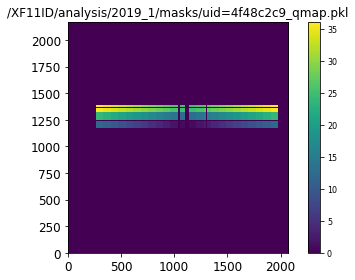

In [26]:
#roi_mask = shift_mask(roi_mask, 10,30)  #if shift mask to get new mask
show_img(roi_mask, aspect=1.0, image_name = fp)#, center=center[::-1])


In [27]:
#%run /home/yuzhang/pyCHX_link/pyCHX/chx_generic_functions.py

* get data

In [28]:
imgs = load_data( uid, md['detector'], reverse= reverse, rot90=rot90  )
md.update( imgs.md );Nimg = len(imgs);
#md['beam_center_x'], md['beam_center_y']  = cx, cy
#if 'number of images'  not in list(md.keys()):
md['number of images']  = Nimg
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

#md['acquire period' ] = md['cam_acquire_period']
#md['exposure time'] =  md['cam_acquire_time']
mdn = md.copy()


The data are: Pipeline processed through proc_func. Original repr:
    EigerImages processed through proc_func. Original repr:
        <Frames>
        Length: 7800 frames
        Frame Shape: 2167 x 2070
        Pixel Datatype: uint32


#### Load Chip mask depeding on detector

In [29]:
if md['detector'] =='eiger1m_single_image':
    Chip_Mask=np.load( '/XF11ID/analysis/2017_1/masks/Eiger1M_Chip_Mask.npy')
elif md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
    Chip_Mask= np.array(np.load( '/XF11ID/analysis/2017_1/masks/Eiger4M_chip_mask.npy'), dtype=bool)
    BadPix =     np.load('/XF11ID/analysis/2018_1/BadPix_4M.npy'  )  
    Chip_Mask.ravel()[BadPix] = 0
elif md['detector'] =='eiger500K_single_image':
    #print('here')
    Chip_Mask=  np.load( '/XF11ID/analysis/2017_1/masks/Eiger500K_Chip_Mask.npy')  #to be defined the chip mask
    Chip_Mask = np.rot90(Chip_Mask)
    pixel_mask = np.rot90(  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool))   )
    
else:
    Chip_Mask = 1
print(Chip_Mask.shape, pixel_mask.shape)

(2167, 2070) (2167, 2070)


In [30]:
use_local_disk = True
import shutil,glob

In [31]:
save_oavs = False
if len(detectors)==2:
    if '_image' in md['detector']:
        pref = md['detector'][:-5]
    else:
        pref=md['detector']
    for k in [ 'beam_center_x', 'beam_center_y','cam_acquire_time','cam_acquire_period','cam_num_images',
             'wavelength', 'det_distance', 'photon_energy']:
        md[k] =  md[ pref + '%s'%k]    
    
    if 'OAV_image' in detectors:
        try:
            save_oavs_tifs(  uid, data_dir )
            save_oavs = True
        except:
            pass
        

In [32]:
print_dict( md,  ['suid', 'number of images', 'uid', 'scan_id', 'start_time', 'stop_time', 'sample', 'Measurement',
                  'acquire period', 'exposure time',  
         'det_distance', 'beam_center_x', 'beam_center_y', ] )

suid--> f8ef1c87
number of images--> 7800
uid--> f8ef1c87-9663-4540-b12c-e15581aa4df8
scan_id--> 7422
start_time--> 2019-03-31 16:24:11
stop_time--> 2019-03-31 16:56:44
sample--> sam5_Si
Measurement--> 65Kr+bombardment, base pressure 5.2 10-6, fan on,  water on,  CHX mech pump on. first bombardment on sam5_Si
acquire period--> 0.25
exposure time--> 0.25
beam_center_x--> 1109.0
beam_center_y--> 1936.0


## Overwrite Some Metadata if Wrong Input

### Define incident beam center (also define reflection beam center for gisaxs)

In [33]:
if scat_geometry =='gi_saxs':
    inc_x0 =  md['beam_center_x'] 
    inc_y0 =  imgs[0].shape[0] - md['beam_center_y']     
    
    refl_x0 =     md['beam_center_x']  
    refl_y0 =     imgs[0].shape[0] - 673   
    
    print( "inc_x0, inc_y0, ref_x0,ref_y0 are: %s %s %s %s."%(inc_x0, inc_y0, refl_x0, refl_y0) )
else:
    if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image' or md['detector']=='eiger1m_single_image':    
        inc_x0 =  imgs[0].shape[0] - md['beam_center_y']   
        inc_y0=   md['beam_center_x']
    elif md['detector'] =='eiger500K_single_image':    
        inc_y0 =  imgs[0].shape[1] - md['beam_center_y']   
        inc_x0 =   imgs[0].shape[0] - md['beam_center_x']
    
    print(inc_x0, inc_y0)
    ###for this particular uid, manually give x0/y0
    #inc_x0 = 1041
    #inc_y0 = 1085

inc_x0, inc_y0, ref_x0,ref_y0 are: 1109.0 231.0 1109.0 1494.


In [34]:
dpix, lambda_, Ldet,  exposuretime, timeperframe, center = check_lost_metadata(
    md, Nimg, inc_x0 = inc_x0, inc_y0=   inc_y0, pixelsize = 7.5*10*(-5) )
if scat_geometry =='gi_saxs':center=center[::-1]
setup_pargs=dict(uid=uidstr, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir)
print_dict( setup_pargs )


Beam_center_x has been changed to 231.0. (no change in raw metadata): 
Beam_center_y has been changed to 1109.0.  (no change in raw metadata): 
uid--> uid=f8ef1c87
dpix--> 0.07500000356230885
Ldet--> 10303.500175476074
lambda_--> 1.2848103
exposuretime--> 0.24999402
timeperframe--> 0.25
center--> [231, 1109]
path--> /XF11ID/analysis/2019_1/pmyint/Results/f8ef1c87-9663-4540-b12c-e15581aa4df8/


In [35]:
setup_pargs

{'uid': 'uid=f8ef1c87',
 'dpix': 0.07500000356230885,
 'Ldet': 10303.500175476074,
 'lambda_': 1.2848103,
 'exposuretime': 0.24999402,
 'timeperframe': 0.25,
 'center': [231, 1109],
 'path': '/XF11ID/analysis/2019_1/pmyint/Results/f8ef1c87-9663-4540-b12c-e15581aa4df8/'}

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change the lines below to give mask filename

In [36]:
if scat_geometry == 'gi_saxs':
    mask_path = '/XF11ID/analysis/2019_1/masks/'    
    mask_name =  'Mar28_2019_4M_GISAXS.npy'
    
elif scat_geometry == 'saxs':
    mask_path = '/XF11ID/analysis/2019_1/masks/'
    if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
        mask_name = 'Feb6_2019_4M_SAXS.npy'     
    elif md['detector'] =='eiger500K_single_image':    
        mask_name = 'Feb6_2019_500K_SAXS.npy'    
        
elif scat_geometry == 'gi_waxs':    
    mask_path = '/XF11ID/analysis/2018_2/masks/'
    mask_name = 'July20_2018_1M_WAXS.npy'

/opt/conda_envs/analysis-2018-2.1/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


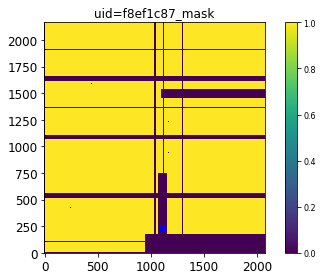

In [37]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = uidstr + '_mask', reverse= reverse, rot90=rot90  ) 
mask =  mask * pixel_mask * Chip_Mask
show_img(mask,image_name = uidstr + '_mask', save=True, path=data_dir, aspect=1, center=center[::-1])
mask_load=mask.copy()
imgsa = apply_mask( imgs, mask )

# Check several frames average  intensity

In [38]:
img_choice_N = 1
img_samp_index = random.sample( range(len(imgs)), img_choice_N) 
avg_img =  get_avg_img( imgsa, img_samp_index, plot_ = False, uid =uidstr)
if avg_img.max() == 0:
    print('There are no photons recorded for this uid: %s'%uid)
    print('The data analysis should be terminated! Please try another uid.')


In [39]:
#show_img( imgsa[1000],  vmin=.1, vmax= 1e1, logs=True, aspect=1,
#         image_name= uidstr + '_img_avg',  save=True, path=data_dir,  cmap = cmap_albula )
print(center[::-1])

[1109, 231]


/opt/conda_envs/analysis-2018-2.1/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


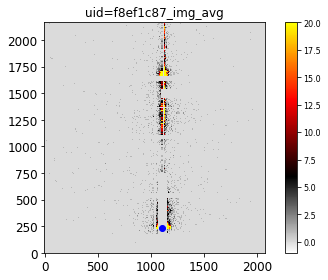

In [40]:
show_img( imgsa[ 5],  vmin = -1, vmax = 20, logs=False, aspect=1, #save_format='tif',
         image_name= uidstr + '_img_avg',  save=True, path=data_dir, cmap=cmap_albula,center=center[::-1])
# select subregion, hard coded center beam location
#show_img( imgsa[180+40*3/0.05][110:110+840*2, 370:370+840*2],  vmin = 0.01, vmax = 20, logs=False, aspect=1, #save_format='tif',
#         image_name= uidstr + '_img_avg',  save=True, path=data_dir, cmap=cmap_albula,center=[845,839])

## Compress Data
* Generate a compressed data with filename
* Replace old mask with a new mask with removed hot pixels
* Do average image
* Do each image sum
* Find badframe_list for where image sum above bad_pixel_threshold
* Check shutter open frame to get good time series


In [41]:
compress=True
photon_occ = len( np.where(avg_img)[0] ) / ( imgsa[0].size)
#compress =  photon_occ < .4  #if the photon ocupation < 0.5, do compress
print ("The non-zeros photon occupation is %s."%( photon_occ))
print("Will " + 'Always ' + ['NOT', 'DO'][compress]  + " apply compress process.")

The non-zeros photon occupation is 0.14570110729898855.
Will Always DO apply compress process.


In [42]:
if  md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
    good_start =    5  #make the good_start at least 0
elif md['detector'] =='eiger500K_single_image': 
    good_start = 100  #5  #make the good_start at least 0
    
elif  md['detector'] =='eiger1m_single_image' or md['detector'] == 'image':    
    good_start =    5    

In [43]:
bin_frame =  False # True  #generally make bin_frame as False
if bin_frame:
    bin_frame_number=4
    acquisition_period = md['acquire period']
    timeperframe = acquisition_period * bin_frame_number
else:
    bin_frame_number =1

In [44]:
force_compress = False
#force_compress = True

Using already created compressed file with filename as :/nsls2/xf11id1/analysis/Compressed_Data/uid_f8ef1c87-9663-4540-b12c-e15581aa4df8.cmp.
The good_start frame number is: 5 
uid=f8ef1c87_fra_5_7800
Total time: 1.086 sec


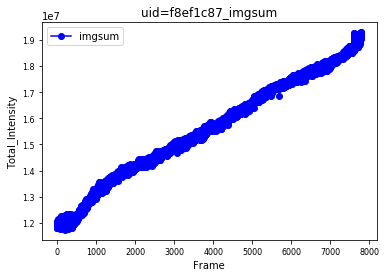

In [45]:
import time
t0= time.time()

if not use_local_disk:
    cmp_path = '/nsls2/xf11id1/analysis/Compressed_Data'
else:
    cmp_path = '/tmp_data/compressed'
    
    
cmp_path = '/nsls2/xf11id1/analysis/Compressed_Data'    
if bin_frame_number==1:   
    cmp_file = '/uid_%s.cmp'%md['uid']
else:
    cmp_file = '/uid_%s_bined--%s.cmp'%(md['uid'],bin_frame_number)
    
filename = cmp_path + cmp_file  
mask2, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
         force_compress= force_compress,  para_compress= para_compress,  bad_pixel_threshold = 1e14,
                                    reverse=reverse, rot90=rot90,
                        bins=bin_frame_number, num_sub= 100, num_max_para_process= 500, with_pickle=True,
                        direct_load_data =use_local_disk, data_path = data_fullpath, )                                  
                                                         
min_inten = 10    
good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
print ('The good_start frame number is: %s '%good_start)
FD = Multifile(filename, good_start, len(imgs)//bin_frame_number )
#FD = Multifile(filename, good_start, 100)
uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
print( uid_ )
plot1D( y = imgsum[ np.array( [i for i in np.arange(good_start, len(imgsum)) if i not in bad_frame_list])],
       title =uidstr + '_imgsum', xlabel='Frame', ylabel='Total_Intensity', legend='imgsum'   )
Nimg = Nimg/bin_frame_number
run_time(t0)

mask2 =  mask * pixel_mask * Chip_Mask
mask_copy = mask.copy()
mask_copy2 = mask.copy()

avg_img *= mask

In [46]:
#%run ~/pyCHX_link/pyCHX/chx_generic_functions.py

In [47]:
try:
    if md['experiment']=='printing':
        #p = md['printing'] #if have this printing key, will do error function fitting to find t_print0
        find_tp0 = True
        t_print0 = ps(  y = imgsum[:400] ) * timeperframe
        print( 'The start time of print: %s.' %(t_print0  ) )
    else:
        find_tp0 = False
        print('md[experiment] is not "printing" -> not going to look for t_0')
        t_print0 = None
except:
    find_tp0 = False
    print('md[experiment] is not "printing" -> not going to look for t_0')
    t_print0 = None


md[experiment] is not "printing" -> not going to look for t_0


/opt/conda_envs/analysis-2018-2.1/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


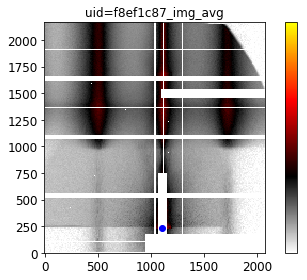

In [48]:
show_img( avg_img*mask,  vmin=1e-3, vmax= 1e7, logs=True, aspect=1, #save_format='tif',
         image_name= uidstr + '_img_avg',  save=True, 
         path=data_dir, center=center[::-1], cmap = cmap_albula )

## Get bad frame list by a polynominal fit

In [49]:
good_end= None # 2000  
if good_end is not None:
    FD = Multifile(filename, good_start, min( len(imgs)//bin_frame_number, good_end) )
    uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
    print( uid_ )
    

In [50]:
re_define_good_start =False
if re_define_good_start:
    good_start = 180
    #good_end = 19700
    good_end = len(imgs)
    FD = Multifile(filename, good_start, good_end) 
    uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
    print( FD.beg, FD.end)

/nsls2/xf11id1/analysis/Analysis_Pipelines/Develop/pyCHX/pyCHX/chx_generic_functions.py:2564: RankWarning: Polyfit may be poorly conditioned
  pol = np.polyfit(x, y, order)


The bad frame list length is: 19


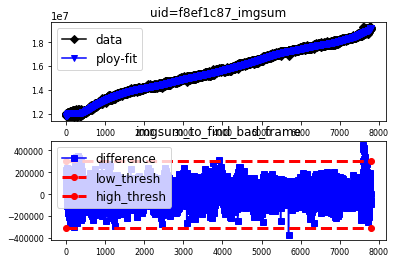

In [51]:
bad_frame_list =  get_bad_frame_list( imgsum, fit='both',  plot=True,polyfit_order = 30,                                      
                        scale= 3.5,  good_start = good_start, good_end=good_end, uid= uidstr, path=data_dir)

print( 'The bad frame list length is: %s'%len(bad_frame_list) )

### Creat new mask by masking the bad pixels and get new avg_img

In [52]:
imgsum_y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])]
imgsum_x = np.arange( len( imgsum_y))
save_lists(  [imgsum_x, imgsum_y], label=['Frame', 'Total_Intensity'],
           filename=uidstr + '_img_sum_t', path= data_dir  )


### Plot time~ total intensity of each frame

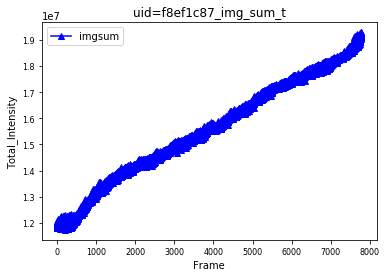

In [53]:
plot1D( y = imgsum_y, title = uidstr + '_img_sum_t', xlabel='Frame', c='b',
       ylabel='Total_Intensity', legend='imgsum', save=True, path=data_dir)

## Get Dynamic Mask (currently designed for 500K)

In [54]:
if  md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
    pass
elif md['detector'] =='eiger500K_single_image':  
    #if md['cam_acquire_period'] <= 0.00015:  #will check this logic
    if imgs[0].dtype == 'uint16':
        print('Create dynamic mask for 500K due to 9K data acquistion!!!')
        bdp = find_bad_pixels_FD( bad_frame_list, FD, img_shape = avg_img.shape, threshold=20 )    
        mask = mask_copy2.copy()
        mask *=bdp 
        mask_copy = mask.copy()
        show_img(  mask, image_name='New Mask_uid=%s'%uid )

# Static Analysis

## SAXS Scattering Geometry

In [55]:
setup_pargs 

{'uid': 'uid=f8ef1c87',
 'dpix': 0.07500000356230885,
 'Ldet': 10303.500175476074,
 'lambda_': 1.2848103,
 'exposuretime': 0.24999402,
 'timeperframe': 0.25,
 'center': [231, 1109],
 'path': '/XF11ID/analysis/2019_1/pmyint/Results/f8ef1c87-9663-4540-b12c-e15581aa4df8/'}

In [56]:
if scat_geometry =='saxs':
    ## Get circular average| * Do plot and save q~iq
    mask = mask_copy.copy()
    hmask = create_hot_pixel_mask( avg_img, threshold = 1e8, center=center, center_radius= 10)
    
    qp_saxs, iq_saxs, q_saxs = get_circular_average( avg_img * Chip_Mask , mask * hmask, pargs=setup_pargs  )
    plot_circular_average( qp_saxs, iq_saxs, q_saxs,  pargs=setup_pargs,  show_pixel=True,
                      xlim=[qp_saxs.min(), qp_saxs.max()*1.0], ylim = [iq_saxs.min(), iq_saxs.max()*2] )
    mask =np.array( mask * hmask, dtype=bool) 

In [57]:
if scat_geometry =='saxs':    
    if run_fit_form:        
        form_res = fit_form_factor( q_saxs,iq_saxs,  guess_values={'radius': 2500, 'sigma':0.05, 
         'delta_rho':1E-10 },  fit_range=[0.0001, 0.015], fit_variables={'radius': T, 'sigma':T, 
         'delta_rho':T},  res_pargs=setup_pargs, xlim=[0.0001, 0.015])  
        
    qr = np.array( [qval_dict[k][0] for k in sorted( qval_dict.keys())] )
    if qphi_analysis ==  False:
        try:
            qr_cal, qr_wid = get_QrQw_From_RoiMask( roi_mask, setup_pargs  ) 
            print(len(qr))         
            if (qr_cal - qr).sum() >=1e-3:
                print( 'The loaded ROI mask might not be applicable to this UID: %s.'%uid)
                print('Please check the loaded roi mask file.')
        except:
            print('Something is wrong with the roi-mask. Please check the loaded roi mask file.')            
            
    
    show_ROI_on_image( avg_img*roi_mask, roi_mask, center, label_on = False, rwidth = 840, alpha=.9,  
                 save=True, path=data_dir, uid=uidstr, vmin= 1e-3,
                 vmax= 1e-1, #np.max(avg_img),
                 aspect=1,
                 show_roi_edge=True,     
                 show_ang_cor = True) 
    plot_qIq_with_ROI( q_saxs, iq_saxs, np.unique(qr), logs=True, uid=uidstr, 
                      xlim=[q_saxs.min(), q_saxs.max()*1.02],#[0.0001,0.08],
                  ylim = [iq_saxs.min(), iq_saxs.max()*1.02],  save=True, path=data_dir)
    
    roi_mask = roi_mask * mask

# Time Depedent I(q) Analysis

In [58]:
if scat_geometry =='saxs':
    Nimg = FD.end - FD.beg 
    time_edge = create_time_slice( Nimg, slice_num= 10, slice_width= 1, edges = None )
    time_edge =  np.array( time_edge ) + good_start
    #print( time_edge )    
    qpt, iqst, qt = get_t_iqc( FD, time_edge, mask*Chip_Mask, pargs=setup_pargs, nx=1500, show_progress= False )
    plot_t_iqc( qt, iqst, time_edge, pargs=setup_pargs, xlim=[qt.min(), qt.max()],
           ylim = [iqst.min(), iqst.max()], save=True )

In [59]:
if run_invariant_analysis:
    if scat_geometry =='saxs':
        invariant = get_iq_invariant( qt, iqst )
        time_stamp = time_edge[:,0] * timeperframe

    if scat_geometry =='saxs':
        plot_q2_iq( qt, iqst, time_stamp,pargs=setup_pargs,ylim=[ -0.001, 0.01] , 
                   xlim=[0.007,0.2],legend_size= 6  )

    if scat_geometry =='saxs':
        plot_time_iq_invariant( time_stamp, invariant, pargs=setup_pargs,  )

    if False:
        iq_int = np.zeros( len(iqst) )
        fig, ax = plt.subplots()
        q = qt
        for i in range(iqst.shape[0]):
            yi = iqst[i] * q**2
            iq_int[i] = yi.sum()
            time_labeli = 'time_%s s'%( round(  time_edge[i][0] * timeperframe, 3) )
            plot1D( x = q, y = yi, legend= time_labeli, xlabel='Q (A-1)', ylabel='I(q)*Q^2', title='I(q)*Q^2 ~ time',
                   m=markers[i], c = colors[i], ax=ax, ylim=[ -0.001, 0.01] , xlim=[0.007,0.2],
                  legend_size=4)

        #print( iq_int )

# GiSAXS Scattering Geometry

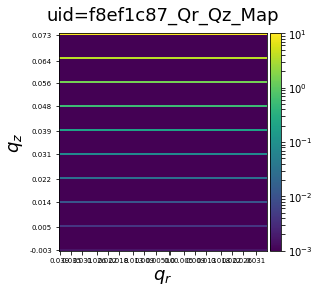

In [60]:
if scat_geometry =='gi_saxs':    
    plot_qzr_map(  qr_map, qz_map, inc_x0, ticks = ticks, data= avg_img, uid= uidstr, path = data_dir   )

## Static Analysis for gisaxs

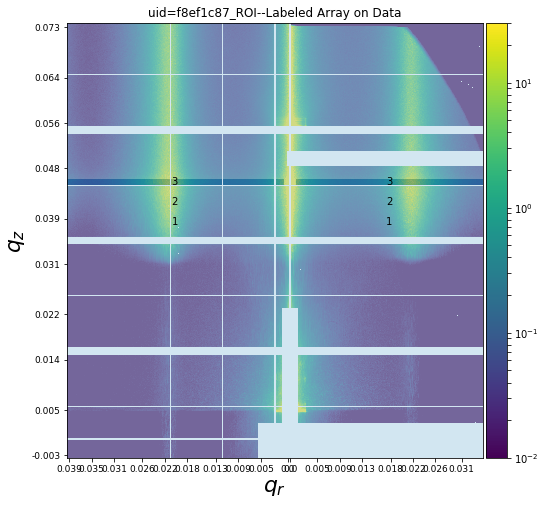

In [61]:
if scat_geometry =='gi_saxs':    
    #roi_masks, qval_dicts = get_gisaxs_roi( Qrs, Qzs, qr_map, qz_map, mask= mask )
    show_qzr_roi( avg_img, roi_masks, inc_x0, ticks[:4], alpha=0.5, save=True, path=data_dir, uid=uidstr )

In [62]:
%run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/crosscor.py'

<Figure size 432x288 with 0 Axes>

In [63]:
%run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/Static_analysis_modified_for_CHX.py'
%run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/Amplification_factors.py'

%run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/autocor.py'
%run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/partitions.py'
%run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/Dynamic_analysis_CHX.py'

In [64]:
from skimage import io
im = io.imread('/home/pmyint/BNLALE20190814-2_004_164_data_000001.tif')
im.shape

(1065, 1030)

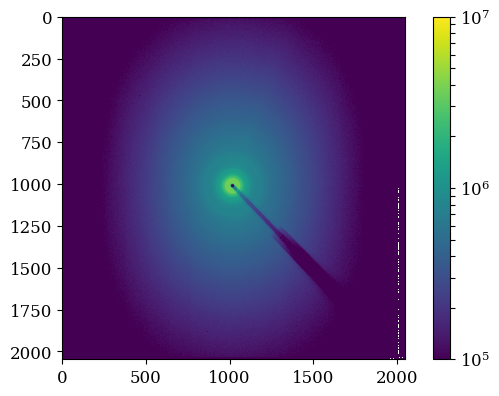

In [88]:
# from skimage import io
# im = io.imread('/home/pmyint/ANL20PDF00016_7_d180_redo-000000.tif')
# im.shape
plt.figure()
plt.imshow(im, norm=LogNorm(vmin=1E5, vmax=1E7))
# plt.imshow(im, vmin=0.01, vmax=1E6)
plt.colorbar()
plt.show()

[1.0970043232046702, 0.728629236610947, 0.5000576567017551, 0.40673666133790487, 0.36841382852203974, 0.32218024500572584, 0.2716711225917827, 0.25028029370895943, 0.26653634560743344, 0.27250771422093023, 0.3120761114273767, 0.30098715176571, 0.39518398693520385, 0.43464860552119966, 0.46974797504476473, 0.42663994244040837, 0.5173204572397212, 0.4833766815741384, 0.4410156546062447, 0.40491284497291646, 0.440869753815893, 0.3408492359878613, 0.4111361280370682, 1.248063774204732, 0.8320556554626413, 7.66853049006663, 0.43605297436461, 0.39389120267806066, 0.2984873014224745, 0.37672384956253535, 0.40671820608662734, 0.4130382882260022, 0.4326670500149702, 0.46522285592461543, 0.3917378420881691, 0.41370885720028194, 0.41512860836506627, 0.4040524863658901, 0.3118829109663619, 0.2990910158593736, 0.30596415388904374, 0.25131768263161824, 0.3230524606260159, 0.239398901444819, 0.3088653229623478, 0.3872244282249877, 0.437432574296281]

In [105]:
#how much the pixel has moved 

((2*np.pi)/(convert_pixel_to_q(0,100)[1])) - (2*np.pi)/(convert_pixel_to_q(3,100)[1]), ((2*np.pi)/(convert_pixel_to_q(0,100)[2])) - (2*np.pi)/(convert_pixel_to_q(0,106)[2])

(0.04320583192827776, 6.472650777582288)

In [96]:
from numpy import r_

def see_speckle_along_a_frame(startY,endY,delY,startX,endX,delX,image,img2shift = 0,Xlogscale= False, normalize = 1, bin_frame = 1, SG_frame = 5, SG_order = 1, SG_box_size = 23, interpolater_on = False):
    """
    will call the functions in autocor.py. make sure to run this first. the g2 calculation in here is done by the code written
    Mark Sutton. It follows the multi-tau method
    
    skip => skips the frame of interest
    bin_num and bin_skip are for normalization 
    bin_num bin over specified number of frames for normalization and bin_skip determines if you want to do binning over the bin_num frames around the next frame or skip to another one. However you bin_num or bin_skip it. the normalzation will match with the t1 or t2 you are considering. This computational structer was conceived first before TTCF binning method. 
    
    skip and bin_skip are not in sync necessarily. 
    
    comparing to TTCF terms. 
    skip --> bin_frame
    bin_num --> SG_Bin_frame
    bin_skip ---> no equivalence in TTCF codes... it lets to skip frames while binning for SG to save computation time
    
    
    star, end del X Y represent the pixel numbers usually from 0 to 2160 in 4M eiger
    start frame and end frame should be within available frame range of the data
    Xlogscale will increase delX in log scale, the increment is determined by Xlog_num
    p0 are the initial parameters for the curefit to try while fitting for the exponents
    normalizewith_Sg = 0 usues the average frame of the entire start-end frame range
    normalizewith_Sg = 1 usues SG smootheing per frame with SG-order and SG-Box_size
    normalizewith_Sg = 2 does binning frames and averaging them and using only the localized average.
    normalizewith_Sg = 3 does binning frames and averaging them and using the smoothened frame of the average.
    
    """
#     numberofframes = endframe - startframe
    image = 0*image
    image += 1
    pixellist=np.where(image.ravel()==1)[0] #list of valid pixels
    #partition in bins using x,y (i,j) indices
    yy,xx=np.unravel_index(pixellist,image.shape)
    Xlogscale = False
    if Xlogscale:
        ylist=mkpartlist(np.arange(startY,endY,delY)) # break points for bins in y
        xlist=mkpartlist(np.round(np.geomspace(startX,endX,Xlog_num),decimals=0).astype(int)) # break points for bins in x
        print(xlist)
        
#         ylist=mkpartlist(np.arange(startY,endY,delY)) # break points for bins in y
#         xlist=mkpartlist(np.round(np.logspace(np.log10(startX), np.log10(endX), num=Xlog_num),decimals=0).astype(int)) # break points for bins in x
        print(xlist)
        
    else:
        ylist=mkpartlist(np.arange(startY,endY,delY)) # break points for bins in y
        xlist=mkpartlist(np.arange(startX,endX,delX)) # break points for bins in x
    plist,bind,xbind,ybind,noperbin,inpixellist,binlist,binxlist,binylist=\
        partition2d(pixellist,xx,xlist,yy,ylist)
    print(xx,yy, xlist, len(xlist))
    
    #how to look at partitions
    ii=0*image
    ii[np.unravel_index(plist,ii.shape)]=bind+1 #bind==0 is not a bin
    # Choose images to test correlations on.
#     img1=image
    img0 = image*ii
    
    
#     image_INTEREST = None
#     image_INTEREST = FD.rdframe(1005+img2shift)
#     for i in np.arange(1006+img2shift,1046+img2shift):
#         image_INTEREST += FD.rdframe(i)
#     img2= image_INTEREST#image - sgolay2d(img1, window_size=SG_box_size, order=SG_order)
    
#     if SG_order == 0:
#         img1 = image
#     else:
#         img1 = sgolay2d(image, window_size=SG_box_size, order=SG_order)
    
    
#     img2= sgolay2d(img1, window_size=SG_box_size, order=SG_order)
#     img1 = sgolay2d(img1, window_size=SG_box_size, order=SG_order)
#     img0 = img1*ii
    img1 = image
    CC = crosscor(img1.shape,mask=ii,normalization="symavg")
    rr=CC(img1,img1)
    
    
    idno = 0 
    #Show how this works for an example
    a=rr[idno] #speckle cross cor
    #solve by quadratic on 3 points
    # print(res[idno,:]) #fit results
    p=np.unravel_index(np.argmax(a, axis=None), a.shape) #position of max
    ax=(a[p[0]-1,p[1]]+a[p[0]+1,p[1]]-2*a[p[0],p[1]])/2.
    dx=(a[p[0]-1,p[1]]-a[p[0]+1,p[1]])/4./ax
    cx=a[p[0],p[1]]-ax*dx*dx
    ay=(a[p[0],p[1]-1]+a[p[0],p[1]+1]-2*a[p[0],p[1]])/2.
    dy=(a[p[0],p[1]-1]-a[p[0],p[1]+1])/4./ay
    cy=a[p[0],p[1]]-ay*dy*dy
    fwhmx=2*np.sqrt(-((cx+cy)/2.-1)/2./ax) 
    fwhmy=2*np.sqrt(-((cx+cy)/2.-1)/2./ay) 
    #print(ax,dx,cx,ay,dy,cy)
    dp=r_[dx,dy] #shif
    # print(p,p+dp)
    # print(a[p[0],p[1]],res[idno,1]+res[idno,6],cx,cy,(cx+cy)/2.)
    # print(res[idno,[4,5]],2*np.sqrt(-(cx-1)/ax/2.),2*np.sqrt(-(cy-1)/ay/2.),fwhmx,fwhmy)
    #Let's calulate for all of them
    res1=np.zeros((len(rr),5))
    idno=0
    for j in tqdm(range(len(rr))):
        a=rr[j]
        p=np.unravel_index(np.argmax(a, axis=None), a.shape) #position of max

    #     p=r_[5,5]+np.unravel_index(np.argmax(a[5:-5,5:-5], axis=None), (10,10))
        ax=(a[p[0]-1,p[1]]+a[p[0]+1,p[1]]-2.0*a[p[0],p[1]])/2.0
        dx=(a[p[0]-1,p[1]]-a[p[0]+1,p[1]])/4.0/ax
        cx=a[p[0],p[1]]-ax*dx*dx
        ay=(a[p[0],p[1]-1]+a[p[0],p[1]+1]-2*a[p[0],p[1]])/2.
        dy=(a[p[0],p[1]-1]-a[p[0],p[1]+1])/4./ay
        cy=a[p[0],p[1]]-ay*dy*dy
        res1[idno,:]=r_[(cx+cy)/2.,p[0]+dx,p[1]+dy,np.sqrt(-cx/2/ax),np.sqrt(-cy/2/ay)]
        idno += 1
        plt.figure()
        plt.imshow(a)
        plt.colorbar()
        plt.show()
        
        
    #the q// range
    x_pixel_range = np.linspace(startX,endX,len(res1[:,0]))
    Y_center = startY + delY//2
    q_parallel_range = []
    for i in range(len(x_pixel_range)):
        q_parallel_range.append(np.round(convert_pixel_to_q(x_pixel_range[i],Y_center)[1],decimals=3))
    q_parallel_range = np.asarray(q_parallel_range)
    
    #plot results beta,px,py,sx,sy
    #note how shift in speckle peaks occurs between these two images.
    fig,((ax0),(ax1),(ax2))=plt.subplots(3,1,figsize=(8,10))
    ax0.plot(q_parallel_range,res1[:,0]-1.0) #beta
    ax0.set_xlabel(r'$q_{||}$ [nm$^{-1}$]')
    ax0.set_ylabel(r'$\beta$')
#     ax0.set_ylim(0.1,0.5)
    
    ax1.plot(q_parallel_range,res1[:,1], label = 'x') #center in x
    ax1.set_xlabel(r'$q_{||}$ [nm$^{-1}$]')
    ax1.set_ylabel('Center')
    
    
    ax1.plot(q_parallel_range,res1[:,2], label = 'x') #center in y
   
    
    ax2.plot(q_parallel_range,res1[:,3], label = 'x') #width in x
    ax2.set_xlabel(r'$q_{||}$ [nm$^{-1}$]')
    ax2.set_ylabel('Width')
#     ax2.set_ylim(0,4)
    ax2.plot(q_parallel_range,res1[:,4], label = 'y') #width in y
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    
#     ax0.plot(res2[j,:,0]-1.0,label="ROI No =%d"%j)#beta
#         ax0.set_xlabel('New binned frame number')
#         ax0.set_ylabel(r'\beta')

#         ax2.plot(res2[j,:,2],'.-',label="Center X =%d"%j)#center x
#         ax2.set_xlabel('New binned frame number')
#         ax2.set_ylabel('Center')

#         ax3.plot(res2[j,:,3]+j,label="Width X =%d"%j)#width x
#         ax3.set_xlabel('New binned frame number')
#         ax3.set_ylabel('Width')

#         ax2.plot(res2[j,:,1],label="Center Y =%d"%j)#center y


#         ax3.plot(res2[j,:,4]+j,label="Witdh Y =%d"%j)#width y

#         ax1.plot(res2[j,:,2]+j,'.-',label="center x with offset =%d"%j) #center x with offset
#         ax1.plot(res2[j,:,1]+j,'.-',label="center y with offset =%d"%j) #center y with offset
#         ax1.set_xlabel('New binned frame number')
#         ax1.set_ylabel(r'Width')

#         ax0.legend(loc='best')
#         ax2.legend(loc='best')

%matplotlib inline
%matplotlib inline

# see_speckle_along_a_frame(startY = 1200,endY = 1301,delY = 100,startX = 100,endX = 2000,delX= 10,img2shift = 5, image = image_INTEREST,normalize = 1, bin_frame = 1, SG_frame = 3, SG_order = 0, SG_box_size = 21, interpolater_on = False)  


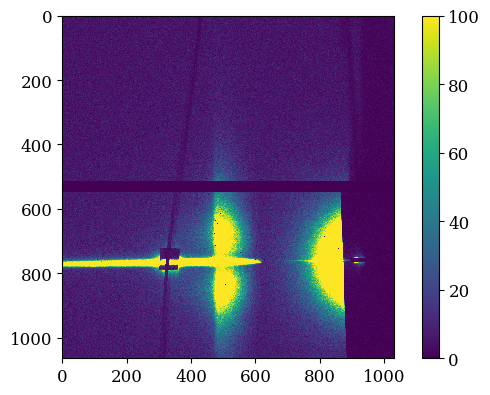

In [135]:
plt.figure()
plt.imshow(im, vmin = 0, vmax =100 )
plt.colorbar()
plt.show()

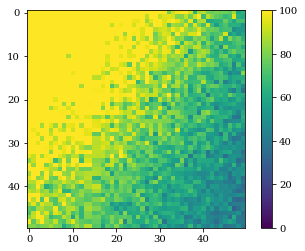

In [143]:
plt.figure()
plt.imshow(im[870:920,500:550], vmin = 0, vmax =100 )
plt.colorbar()
plt.show()

100%|██████████| 1/1 [00:00<00:00, 362.92it/s]


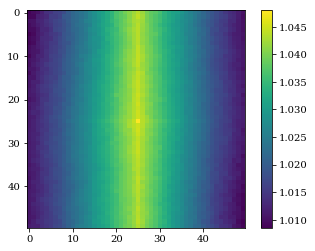

1.0479866443578116 24.997956767453747 24.958494550600186 13.346650238092357 11.503776144575916


In [144]:
img1 = im[820:870,500:550]
im2 = io.imread('/home/pmyint/BNLALE20190814-2_004_165_data_000001.tif')
img2 = im2[820:870,500:550]
ii=0*img1
ii += 1 #bind==0 is not a bin
# Choose images to test correlations on.
#     img1=image
CC = crosscor(img1.shape,mask=ii,normalization="symavg")
rr=CC(img1,img2)
plt.figure()
plt.imshow(rr)
plt.colorbar()
plt.show()
a=rr #speckle cross cor
#solve by quadratic on 3 points
# print(res[idno,:]) #fit results
p=np.unravel_index(np.argmax(a, axis=None), a.shape) #position of max
ax=(a[p[0]-1,p[1]]+a[p[0]+1,p[1]]-2*a[p[0],p[1]])/2.
dx=(a[p[0]-1,p[1]]-a[p[0]+1,p[1]])/4./ax
cx=a[p[0],p[1]]-ax*dx*dx
ay=(a[p[0],p[1]-1]+a[p[0],p[1]+1]-2*a[p[0],p[1]])/2.
dy=(a[p[0],p[1]-1]-a[p[0],p[1]+1])/4./ay
cy=a[p[0],p[1]]-ay*dy*dy
fwhmx=2*np.sqrt(-((cx+cy)/2.-1)/2./ax) 
fwhmy=2*np.sqrt(-((cx+cy)/2.-1)/2./ay) 
#print(ax,dx,cx,ay,dy,cy)
dp=r_[dx,dy] #shif
print((cx+cy)/2.,p[0]+dx,p[1]+dy,np.sqrt(-cx/2/ax),np.sqrt(-cy/2/ay))

[   0    1    2 ... 1027 1028 1029] [   0    0    0 ... 1064 1064 1064] [820. 870.] 2


/home/pmyint/analysis/2019_1/pmyint/ResPipelines/Dynamic_analysis_CHX.py:87: RuntimeWarning: invalid value encountered in double_scalars
  #     expected_values = KWW(timeinfo, params[0],params[1],params[2])
/home/pmyint/analysis/2019_1/pmyint/ResPipelines/Dynamic_analysis_CHX.py:90: RuntimeWarning: invalid value encountered in double_scalars
  #     chi_square = test[0]


/home/pmyint/analysis/2019_1/pmyint/ResPipelines/Dynamic_analysis_CHX.py:108: RuntimeWarning: invalid value encountered in double_scalars
  plt.xscale('log')
/home/pmyint/analysis/2019_1/pmyint/ResPipelines/Dynamic_analysis_CHX.py:111: RuntimeWarning: invalid value encountered in double_scalars
  #     plt.savefig(DD.DD['filename'][:-4]+'_start{0}'.format(startframe) +


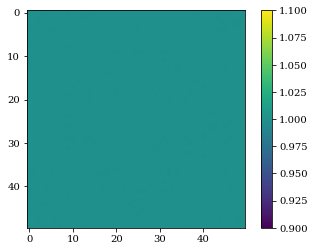

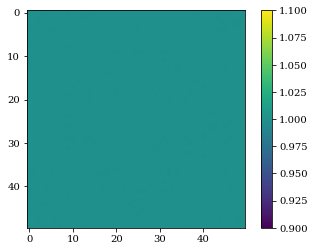

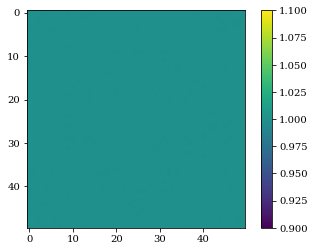

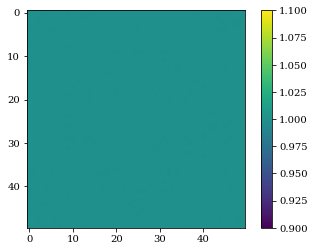

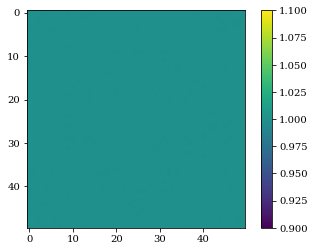

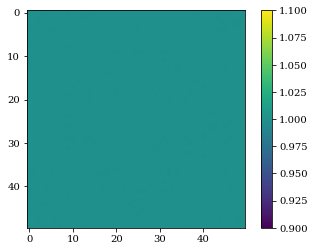

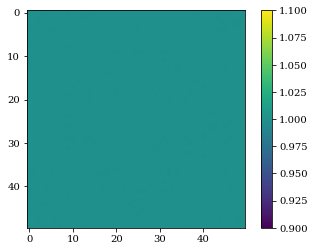

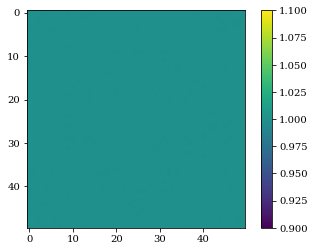

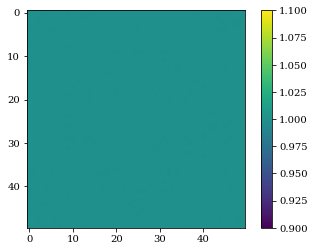

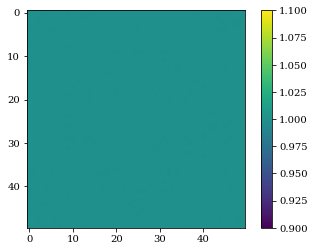

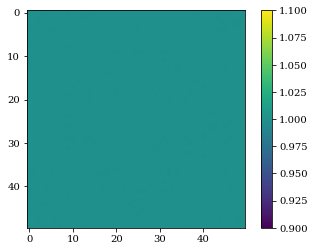

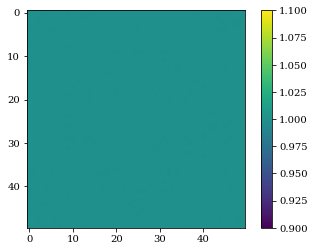

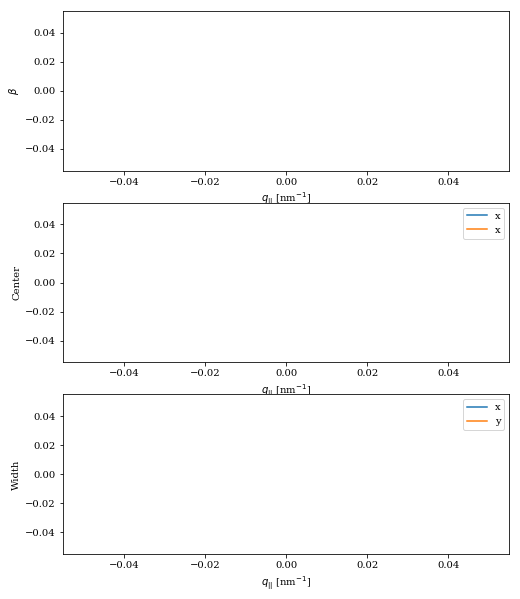

In [98]:
see_speckle_along_a_frame(startX = 820,endX = 871,delX = 50,startY = 200,endY = 801,delY= 50,img2shift = 0, image = im,normalize = 1, bin_frame = 1, SG_frame = 3, SG_order = 0, SG_box_size = 21, interpolater_on = False)  

  1%|▏         | 1/75 [00:03<04:32,  3.68s/it]/s]

[0.08491647826546922, 0.0515767101442548, 0.05078669817006576, 0.02688037699035739, 0.037981921424602216, 0.036203440210990756] 0.04805760420095669 19



  3%|▎         | 2/75 [00:06<03:40,  3.02s/it]s]

[0.06485845463651652, 0.04321463117766844, 0.040505136803161035, 0.03566996610339146, 0.03982745384745834, 0.04737016800975513] 0.04524096842965849 17



  4%|▍         | 3/75 [00:08<03:23,  2.82s/it]/s]

[0.06280045604813189, 0.07054639828110698, 0.03203692045632134, 0.034574404777854006, 0.04776443699678046, 0.05145417842048072] 0.0498627991634459 17



  5%|▌         | 4/75 [00:10<03:09,  2.66s/it]s]

[0.04964588004495263, 0.051614980487351136, 0.046326594913910446, 0.032321628389317736, 0.04547616335937743, 0.049556168769339104] 0.04582356932737475 15



  7%|▋         | 5/75 [00:13<03:02,  2.61s/it]/s]

[0.05654904042599629, 0.032588486534567807, 0.07121981990723092, 0.04899412961736149, 0.02971638171070845, 0.022916483463826687] 0.04366405694328194 17



  8%|▊         | 6/75 [00:15<02:54,  2.53s/it]s]

[0.06372793500873097, 0.04917469927863061, 0.04506923592308487, 0.04588952727002504, 0.028804772116651334, 0.05851259101131068] 0.04852979343473892 17



  9%|▉         | 7/75 [00:18<03:01,  2.67s/it]s]

[0.06328848068911563, 0.04081055579276893, 0.044671619151603004, 0.05084173217378729, 0.03994656912290262, 0.05255062790173648] 0.04868493080531899 21



 11%|█         | 8/75 [00:21<03:02,  2.72s/it]s]

[0.060905600069782295, 0.03924652059914635, 0.03576931669615191, 0.042351046694290684, 0.051540805569741055, 0.05136559861921075] 0.04686314804138717 19



 12%|█▏        | 9/75 [00:24<02:58,  2.71s/it]/s]

[0.054145228442114224, 0.047952776270615116, 0.0397530701512494, 0.05310930731688557, 0.030747317424121068, 0.03707201866553267] 0.043796619711753006 17



 13%|█▎        | 10/75 [00:26<02:54,  2.68s/it]s]

[0.042953140621308616, 0.04924891030633649, 0.03502735402407353, 0.05222739218171912, 0.04625285599644635, 0.04747474738337898] 0.04553073341887718 17



 15%|█▍        | 11/75 [00:29<02:53,  2.72s/it]s]

[0.058810309061148036, 0.050576391947619426, 0.04437328169704413, 0.034334006895466285, 0.041611964797827916, 0.05531895403549014] 0.04750415140576599 19



 16%|█▌        | 12/75 [00:32<02:50,  2.70s/it]s]

[0.05884673083655079, 0.03447182970917351, 0.0693948090384604, 0.04224670337816394, 0.020355284259298667, 0.05546477317085263] 0.04679668839874999 17



 17%|█▋        | 13/75 [00:34<02:45,  2.66s/it]s]

[0.07228031984431205, 0.05590092212863906, 0.04399398643760266, 0.050408223400253416, 0.030682976044991817, 0.04439803096807804] 0.04961074313731284 15



 19%|█▊        | 14/75 [00:36<02:40,  2.64s/it]s]

[0.05384274739741368, 0.026370854793007936, 0.03580128762494206, 0.044632690539782915, 0.04553624046756144, 0.06526039018952412] 0.04524070183537202 17



 20%|██        | 15/75 [00:38<02:34,  2.58s/it]]

[0.04605313615468676, 0.019194462081491448, 0.044642164488700065, 0.04462227886017045, 0.04209306767382737, 0.059794211769966576] 0.042733220171473775 15



 21%|██▏       | 16/75 [00:41<02:32,  2.58s/it]s]

[0.06305742229820255, 0.04524919084486556, 0.041895159334587984, 0.04751381487300521, 0.03533067779441068, 0.05062922756255861] 0.0472792487846051 17



 23%|██▎       | 17/75 [00:43<02:27,  2.54s/it]s]

[0.05102114789096346, 0.04107010265913891, 0.045649958376517974, 0.05090088612308019, 0.03682446130168904, 0.047875716904518084] 0.045557045542651275 15



 24%|██▍       | 18/75 [00:44<02:22,  2.49s/it]s]

[0.06834559064347623, 0.05915712281579899, 0.051267102511344254, 0.04899820844200975, 0.03159488639061081, 0.03301008509811143] 0.04872883265022524 15



 25%|██▌       | 19/75 [00:46<02:17,  2.46s/it]s]

[0.05550346439683529, 0.05364281482243083, 0.043607255260962985, 0.04583324909567876, 0.032180336158098344, 0.04238156004894855] 0.04552477996382579 15



 27%|██▋       | 20/75 [00:48<02:12,  2.42s/it]s]

[0.055944373472254005, 0.03393452656150453, 0.04516168068080062, 0.054732462875369814, 0.06019554847844, 0.04733884844370806] 0.04955124008534617 13



 28%|██▊       | 21/75 [00:49<02:07,  2.37s/it]s]

[0.040071937880734376, 0.05235263429965453, 0.0457613355399209, 0.043665180342184584, 0.05018316239286569, 0.03694315521329328] 0.044829567611442224 13



 29%|██▉       | 22/75 [00:50<02:02,  2.32s/it]s]

[0.045485107360420995, 0.05372996852658751, 0.04109503018849603, 0.05540981958086344, 0.02111647345298362, 0.03951799480883844] 0.04272573231969834 13



 31%|███       | 23/75 [00:52<01:58,  2.28s/it]s]

[0.05993793877740439, 0.03237784950274958, 0.044629203406044704, 0.055740532629283024, 0.03276194741170513, 0.06988983294955298] 0.049222884112789966 13



 32%|███▏      | 24/75 [00:54<01:56,  2.29s/it]s]

[0.08075557537729128, 0.03958521794355563, 0.04738792848708884, 0.037625139481750836, 0.03438270492451334, 0.04488017266508115] 0.04743612314654685 15



 33%|███▎      | 25/75 [00:57<01:54,  2.29s/it]]

[0.07154191178929903, 0.05461164029290311, 0.04220930325974326, 0.055171211072568616, 0.03569610248255972, 0.039087491083728665] 0.0497196099968004 15



 35%|███▍      | 26/75 [00:59<01:51,  2.28s/it]s]

[0.06253877486890813, 0.033273645055438505, 0.04343380270598596, 0.0639698088883538, 0.0404209710854766, 0.04795014106611051] 0.04859785727837892 15



 36%|███▌      | 27/75 [01:00<01:48,  2.25s/it]]

[0.07803418335109824, 0.04601344610003966, 0.043600079027542815, 0.04464611274991448, 0.04363302555092319, 0.04328702232168791] 0.04986897818353438 13



 37%|███▋      | 28/75 [01:03<01:45,  2.25s/it]s]

[0.06481263377517132, 0.04264622199765733, 0.0427004089716998, 0.04917335569975334, 0.041126619663352404, 0.0582733710126353] 0.049788768520044914 15



 39%|███▊      | 29/75 [01:05<01:44,  2.27s/it]s]

[0.06508190434370897, 0.0444447255101148, 0.050627646864848774, 0.03857072414915619, 0.04548433176280797, 0.05273437421835747] 0.049490617808165695 17



 40%|████      | 30/75 [01:08<01:42,  2.28s/it]s]

[0.0681348358963838, 0.036744485471783994, 0.04059770975174093, 0.05260035794392648, 0.03673415859451867, 0.05351987530757074] 0.04805523716098744 17



 41%|████▏     | 31/75 [01:10<01:40,  2.29s/it]s]

[0.07480888283069675, 0.04372800878183103, 0.04186164023198247, 0.042798025686790364, 0.0436869168536731, 0.048554508306598576] 0.04923966378192871 17



 43%|████▎     | 32/75 [01:12<01:37,  2.28s/it]s]

[0.07734951437212034, 0.03845829717653859, 0.04806328713503438, 0.05104083266849435, 0.03734844938901705, 0.04410174259979183] 0.049393687223499426 15



 44%|████▍     | 33/75 [01:14<01:35,  2.27s/it]s]

[0.07182173894418087, 0.03611307749450954, 0.04735578291062437, 0.046981051739968915, 0.04218425601324616, 0.054177033566735755] 0.04977215677821093 15



 45%|████▌     | 34/75 [01:16<01:32,  2.25s/it]s]

[0.07473722772305291, 0.03945096602670084, 0.042516725427220736, 0.04280886756830027, 0.042906603403907395, 0.04604083859707431] 0.04807687145770941 15



 47%|████▋     | 35/75 [01:18<01:30,  2.25s/it]s]

[0.0728557467070714, 0.03690284782413511, 0.044939891865774406, 0.04520077894834462, 0.04515828773303743, 0.04250753688892095] 0.04792751499454732 17



 48%|████▊     | 36/75 [01:21<01:28,  2.26s/it]s]

[0.06786957155994333, 0.0395679736976009, 0.044828730441569764, 0.0467044132055221, 0.0466500451858296, 0.04491909785107495] 0.048423305323590106 17



 49%|████▉     | 37/75 [01:24<01:26,  2.28s/it]]

[0.06664068118897548, 0.03496794805199932, 0.04533895331773041, 0.04567890580652034, 0.05008138811446394, 0.04542075816043467] 0.04802143910668736 17



 51%|█████     | 38/75 [01:26<01:24,  2.28s/it]]

[0.06796387344094001, 0.03568838755475334, 0.04057454797046667, 0.051839925697181766, 0.05590595546646049, 0.04635547819373076] 0.049721361387255504 17



 52%|█████▏    | 39/75 [01:29<01:22,  2.30s/it]]

[0.0681184243315196, 0.037822840888060094, 0.043078497178991704, 0.05482959931299369, 0.0539584879229178, 0.0410816062562831] 0.049814909315127665 17



 53%|█████▎    | 40/75 [01:32<01:21,  2.32s/it]s]

[0.064477461773083, 0.03645159697048106, 0.04272574434403298, 0.05122844492830536, 0.056956910284079454, 0.04342091682179472] 0.049210179186962764 21



 55%|█████▍    | 41/75 [01:36<01:19,  2.35s/it]s]

[0.06617639266264175, 0.03645067240913935, 0.0454554976598629, 0.05024208434111932, 0.05366901807050595, 0.040737678539204625] 0.048788557280412315 19



 56%|█████▌    | 42/75 [01:40<01:18,  2.38s/it]s]

[0.06129701892645323, 0.036464417015062534, 0.042487872892827516, 0.05417741601289228, 0.05445781757285828, 0.04308107244693504] 0.04866093581117148 21



 57%|█████▋    | 43/75 [01:43<01:16,  2.40s/it]]

[0.059777131027103136, 0.038115057042323874, 0.04338885936123282, 0.049001264224999064, 0.05071681577777376, 0.04620102351785693] 0.047866691825214934 19



 59%|█████▊    | 44/75 [01:46<01:15,  2.43s/it]s]

[0.05767762941376642, 0.04003362067288596, 0.039253258150887094, 0.05216002261547681, 0.05453885709052164, 0.046676189055808504] 0.04838992949989107 21



 60%|██████    | 45/75 [01:51<01:14,  2.48s/it]s]

[0.05601116714871712, 0.043509779934459925, 0.04232823606569136, 0.04887632102312933, 0.05450321956966486, 0.044894678527719334] 0.04835390037823032 23



 61%|██████▏   | 46/75 [01:55<01:12,  2.51s/it]s]

[0.052444569902171834, 0.041763512585041074, 0.046492495737533446, 0.047103956500816224, 0.05845351390210807, 0.05107347489626202] 0.04955525392065544 23



 63%|██████▎   | 47/75 [01:59<01:11,  2.54s/it]s]

[0.051586383287708815, 0.04572987234684622, 0.04524327631008562, 0.04964583755158736, 0.057024586778843256, 0.04702085802656475] 0.049375135716939335 23



 64%|██████▍   | 48/75 [02:04<01:10,  2.59s/it]s]

[0.05165174496372815, 0.04409397392581149, 0.04199988938692556, 0.05020528497215304, 0.054924402906469494, 0.0529030359180056] 0.04929638867884889 27



 65%|██████▌   | 49/75 [02:10<01:09,  2.65s/it]]

[0.050126577699031394, 0.044244621970552345, 0.0457174719009501, 0.05185252810652319, 0.0533477567006968, 0.05416050258904481] 0.049908243161133105 27



 67%|██████▋   | 50/75 [02:15<01:07,  2.70s/it]s]

[0.05028867323862318, 0.0458670451328993, 0.04395994992471919, 0.05051694390752304, 0.05382297447781892, 0.05013445811582473] 0.04909834079956806 27



 68%|██████▊   | 51/75 [02:21<01:06,  2.77s/it]s]

[0.04588770359588645, 0.0443121908890598, 0.04511453621181749, 0.05286379540370856, 0.05350130651627971, 0.05335896946407104] 0.049173083680137175 29



 69%|██████▉   | 52/75 [02:26<01:04,  2.81s/it]s]

[0.04840416294866179, 0.044245975902765355, 0.04720784125354771, 0.05524276786081472, 0.05128432454541976, 0.049519236488255736] 0.04931738483324418 25



 71%|███████   | 53/75 [02:31<01:02,  2.85s/it]s]

[0.0470440614159382, 0.04358113611726644, 0.04957399353301062, 0.05442547006468579, 0.04939817516092382, 0.050280391566393856] 0.04905053797636979 27



 72%|███████▏  | 54/75 [02:37<01:01,  2.92s/it]s]

[0.04812814211467087, 0.045402100428751035, 0.04575009953182074, 0.05289715786655136, 0.05095773780137813, 0.05010410536344301] 0.04887322385110252 31



 73%|███████▎  | 55/75 [02:43<00:59,  2.97s/it]s]

[0.047102346821128016, 0.04782601619403515, 0.047055970748490994, 0.053035688415309146, 0.04844716361915369, 0.05039259123271567] 0.04897662950513878 31



 75%|███████▍  | 56/75 [02:49<00:57,  3.03s/it]s]

[0.049383879271966524, 0.048885356896141374, 0.046621082895910604, 0.05034683515792926, 0.04831715088882449, 0.05332609845613878] 0.04948006726115184 29



 76%|███████▌  | 57/75 [02:55<00:55,  3.07s/it]s]

[0.049629316965089654, 0.048412814756016775, 0.04814091148025401, 0.05168807305463985, 0.04449688307228672, 0.05473170347301215] 0.04951661713354986 27



 77%|███████▋  | 58/75 [03:00<00:52,  3.12s/it]s]

[0.051633552887018874, 0.05100366217438035, 0.04938660519541971, 0.04814006781723679, 0.04466680329778483, 0.047754364231676893] 0.048764175933919574 27



 79%|███████▊  | 59/75 [03:06<00:50,  3.16s/it]s]

[0.05228976893064985, 0.050725380800993314, 0.04440381625983103, 0.05153605406967676, 0.04911705721204562, 0.04793339743471248] 0.04933424578465151 31



 80%|████████  | 60/75 [03:12<00:48,  3.21s/it]s]

[0.050140577805701136, 0.048445072364040165, 0.044348071938721034, 0.05012725104850757, 0.04808704308081091, 0.05708922412298456] 0.04970620672679423 29



 81%|████████▏ | 61/75 [03:18<00:45,  3.26s/it]s]

[0.05335043766199998, 0.05151783816702249, 0.04543530501336224, 0.0490900029393031, 0.04587659255626386, 0.05230956888298621] 0.04959662420348965 29



 83%|████████▎ | 62/75 [03:24<00:42,  3.30s/it]]

[0.0531280222773689, 0.050263530250733934, 0.043553196230088576, 0.05183872797053746, 0.05118093640736765, 0.04998763824119434] 0.04999200856288181 27



 84%|████████▍ | 63/75 [03:31<00:40,  3.35s/it]s]

[0.05147463901132965, 0.049137148372597306, 0.04330219220574727, 0.04720648613453671, 0.05054843685930521, 0.05168019034437976] 0.04889151548798265 33



 85%|████████▌ | 64/75 [03:37<00:37,  3.39s/it]]

[0.05472561906050455, 0.05050349328773329, 0.04324238879211806, 0.04901189396993377, 0.0475744575228072, 0.04722899838971717] 0.04871447517046901 29



 87%|████████▋ | 65/75 [03:43<00:34,  3.43s/it]]

[0.054051208186160604, 0.053963324701553184, 0.043772926269012524, 0.049347893872169646, 0.04555472263269511, 0.045720921539611936] 0.0487351662002005 29



 88%|████████▊ | 66/75 [03:48<00:31,  3.47s/it]s]

[0.053605572011896196, 0.04795246025929889, 0.041544904930242765, 0.050724198503803386, 0.04788230730189791, 0.04998667745242491] 0.04861602007659401 29



 89%|████████▉ | 67/75 [03:53<00:27,  3.49s/it]s]

[0.05244353773890653, 0.05527456344504866, 0.04198730750150914, 0.054960116769997125, 0.04844688453993151, 0.04592032709368521] 0.04983878951484636 27



 91%|█████████ | 68/75 [03:59<00:24,  3.52s/it]s]

[0.054118993203581045, 0.05085917735462431, 0.041391876910949144, 0.049335381167509684, 0.050950642026103665, 0.05172072731466404] 0.04972946632957198 29



 92%|█████████▏| 69/75 [04:05<00:21,  3.55s/it]s]

[0.05433025223164534, 0.050304898581181146, 0.04235284429916386, 0.04792058856387271, 0.04941840987866386, 0.0494151842861017] 0.04895702964010477 29



 93%|█████████▎| 70/75 [04:10<00:17,  3.58s/it]s]

[0.054751019928148015, 0.049279681692536936, 0.040177869432874935, 0.04495535612434942, 0.051898169040390796, 0.050431703526457206] 0.04858229995745955 29



 95%|█████████▍| 71/75 [04:16<00:14,  3.61s/it]s]

[0.05640839221049676, 0.04951533620155191, 0.04257892296193888, 0.04997310612506656, 0.04883018089533664, 0.049537579511159] 0.04947391965092496 27



 96%|█████████▌| 72/75 [04:22<00:10,  3.64s/it]]

[0.056731248820389046, 0.05108627905901586, 0.04118818427343718, 0.047080188095873554, 0.04820679868974498, 0.04870230240757589] 0.048832500224339416 29



 97%|█████████▋| 73/75 [04:27<00:07,  3.66s/it]s]

[0.057650164848561225, 0.05465389876671933, 0.04657368873646495, 0.05019250834713973, 0.04515602572622157, 0.044420578538032274] 0.049774477493856516 25



 99%|█████████▊| 74/75 [04:32<00:03,  3.68s/it]s]

[0.056608566227501544, 0.05639622622330176, 0.04633248090653597, 0.04381779785158524, 0.048836539490780595, 0.0463147183328354] 0.04971772150542342 27



100%|██████████| 75/75 [04:37<00:00,  3.70s/it]s]


[0.05471160354435778, 0.054440948145586754, 0.044868278644335735, 0.045685868890600556, 0.05050711482259551, 0.04202827758644978] 0.04870701527232102 29


100%|██████████| 58/58 [00:14<00:00,  3.91it/s]6it/s]


41 box size 40 frame bin, norm 3, 25-1SG 


<Figure size 720x445 with 0 Axes>

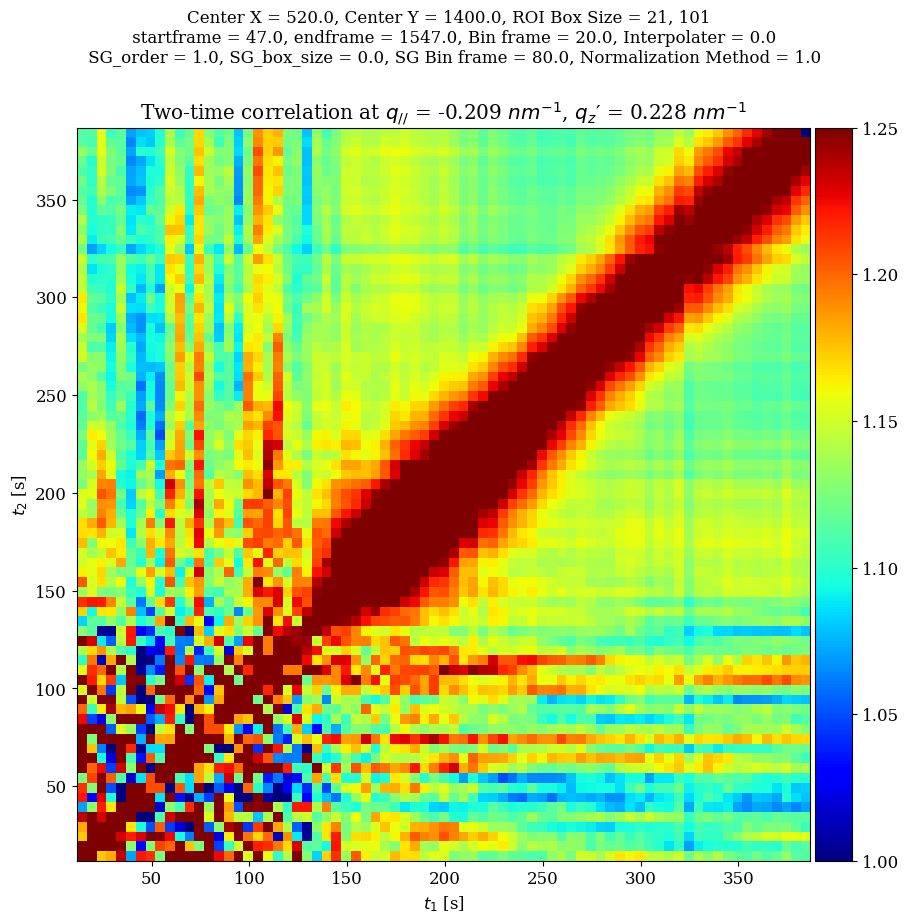

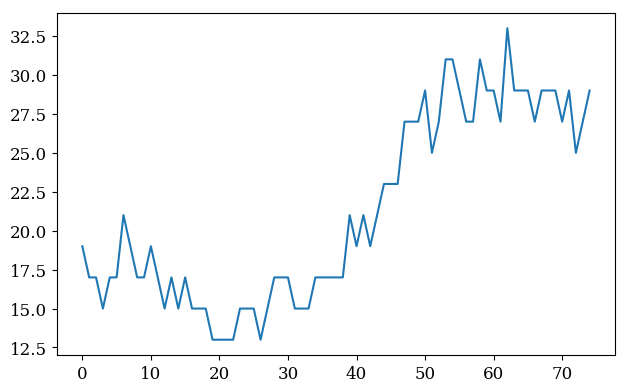

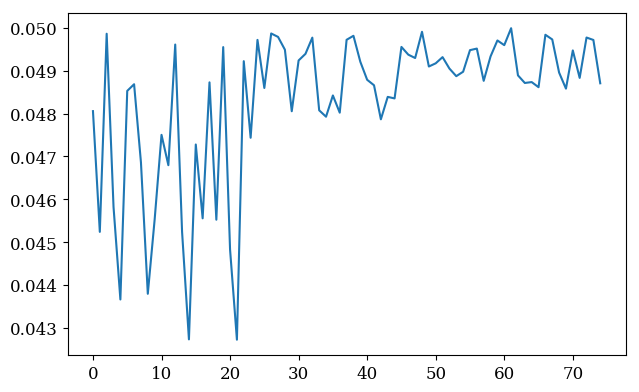

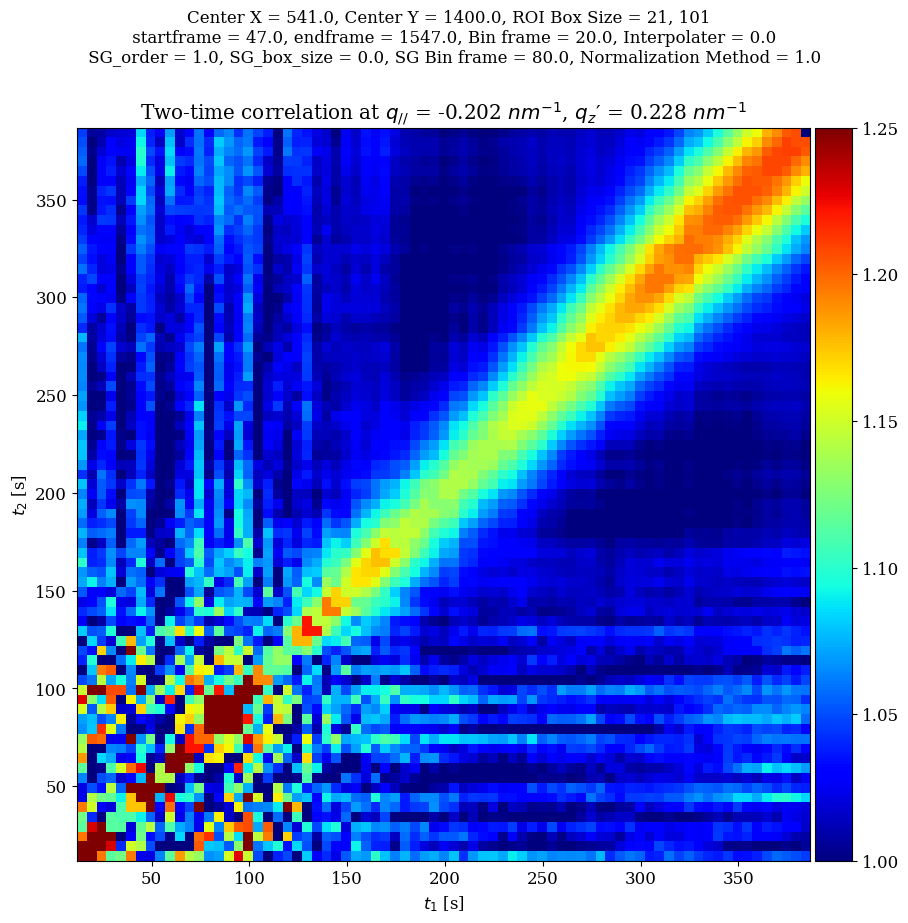

In [145]:
%run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/Dynamic_analysis_CHX.py'
from tqdm import tqdm
CenterXs,Inor_all,TTCF2, TTCFs = None, None, None, None
#7735

CenterXs,Inor_all, contrasts, Windows = collect_normalize(startframe = 47 ,endframe = 7735//5 , centerx_start = 100, centerx_end = 1300, centery = 1400,peak_in_X = 550, boxsize = (21,101), bin_frame = 20, normalize = 1, SG_window = 0, SG_order = 1,  SG_bin_frame = 80, interpolate = 0)
TTCF2, TTCFs = TTCF(CenterXs,Inor_all)
print('41 box size 40 frame bin, norm 3, 25-1SG ')
plotTTCF(TTCFs[20], color_min = 1 , color_max = 1.25, save = 0)
plt.figure()
plt.plot(Windows)
plt.show()
plt.figure()
plt.plot(contrasts)
plt.show()
plotTTCF(TTCFs[21], color_min = 1 , color_max = 1.25, save = 0)

  1%|▏         | 1/75 [00:04<05:34,  4.52s/it]/s]

[0.08491647826546922, 0.0515767101442548, 0.05078669817006576, 0.02688037699035739, 0.037981921424602216, 0.036203440210990756] 0.04805760420095669 19



  3%|▎         | 2/75 [00:06<04:01,  3.30s/it]/s]

[0.06485845463651652, 0.04321463117766844, 0.040505136803161035, 0.03566996610339146, 0.03982745384745834, 0.04737016800975513] 0.04524096842965849 17



  4%|▍         | 3/75 [00:08<03:35,  3.00s/it]/s]

[0.06280045604813189, 0.07054639828110698, 0.03203692045632134, 0.034574404777854006, 0.04776443699678046, 0.05145417842048072] 0.0498627991634459 17



  5%|▌         | 4/75 [00:11<03:19,  2.80s/it]/s]

[0.04964588004495263, 0.051614980487351136, 0.046326594913910446, 0.032321628389317736, 0.04547616335937743, 0.049556168769339104] 0.04582356932737475 15



  7%|▋         | 5/75 [00:13<03:09,  2.70s/it]/s]

[0.05654904042599629, 0.032588486534567807, 0.07121981990723092, 0.04899412961736149, 0.02971638171070845, 0.022916483463826687] 0.04366405694328194 17



  8%|▊         | 6/75 [00:16<03:04,  2.68s/it]/s]

[0.06372793500873097, 0.04917469927863061, 0.04506923592308487, 0.04588952727002504, 0.028804772116651334, 0.05851259101131068] 0.04852979343473892 17



  9%|▉         | 7/75 [00:19<03:11,  2.81s/it]/s]

[0.06328848068911563, 0.04081055579276893, 0.044671619151603004, 0.05084173217378729, 0.03994656912290262, 0.05255062790173648] 0.04868493080531899 21



 11%|█         | 8/75 [00:22<03:08,  2.82s/it]/s]

[0.060905600069782295, 0.03924652059914635, 0.03576931669615191, 0.042351046694290684, 0.051540805569741055, 0.05136559861921075] 0.04686314804138717 19



 12%|█▏        | 9/75 [00:25<03:03,  2.79s/it]/s]

[0.054145228442114224, 0.047952776270615116, 0.0397530701512494, 0.05310930731688557, 0.030747317424121068, 0.03707201866553267] 0.043796619711753006 17



 13%|█▎        | 10/75 [00:27<02:59,  2.76s/it]]

[0.042953140621308616, 0.04924891030633649, 0.03502735402407353, 0.05222739218171912, 0.04625285599644635, 0.04747474738337898] 0.04553073341887718 17



 15%|█▍        | 11/75 [00:30<02:57,  2.78s/it]s]

[0.058810309061148036, 0.050576391947619426, 0.04437328169704413, 0.034334006895466285, 0.041611964797827916, 0.05531895403549014] 0.04750415140576599 19



 16%|█▌        | 12/75 [00:33<02:53,  2.75s/it]s]

[0.05884673083655079, 0.03447182970917351, 0.0693948090384604, 0.04224670337816394, 0.020355284259298667, 0.05546477317085263] 0.04679668839874999 17



100%|██████████| 57/57 [00:00<00:00, 1454.93it/s]

[0.07228031984431205, 0.05590092212863906, 0.04399398643760266, 0.050408223400253416, 0.030682976044991817, 0.04439803096807804] 0.04961074313731284 15



100%|██████████| 57/57 [00:00<00:00, 1512.91it/s]

[0.05384274739741368, 0.026370854793007936, 0.03580128762494206, 0.044632690539782915, 0.04553624046756144, 0.06526039018952412] 0.04524070183537202 17



100%|██████████| 57/57 [00:00<00:00, 829.72it/s]

[0.04605313615468676, 0.019194462081491448, 0.044642164488700065, 0.04462227886017045, 0.04209306767382737, 0.059794211769966576] 0.042733220171473775 15



100%|██████████| 57/57 [00:00<00:00, 1509.48it/s]

[0.06305742229820255, 0.04524919084486556, 0.041895159334587984, 0.04751381487300521, 0.03533067779441068, 0.05062922756255861] 0.0472792487846051 17



100%|██████████| 57/57 [00:00<00:00, 804.31it/s]

[0.05102114789096346, 0.04107010265913891, 0.045649958376517974, 0.05090088612308019, 0.03682446130168904, 0.047875716904518084] 0.045557045542651275 15



100%|██████████| 57/57 [00:00<00:00, 792.59it/s]

[0.06834559064347623, 0.05915712281579899, 0.051267102511344254, 0.04899820844200975, 0.03159488639061081, 0.03301008509811143] 0.04872883265022524 15



100%|██████████| 57/57 [00:00<00:00, 843.89it/s]

[0.05550346439683529, 0.05364281482243083, 0.043607255260962985, 0.04583324909567876, 0.032180336158098344, 0.04238156004894855] 0.04552477996382579 15



100%|██████████| 57/57 [00:00<00:00, 786.05it/s]

[0.055944373472254005, 0.03393452656150453, 0.04516168068080062, 0.054732462875369814, 0.06019554847844, 0.04733884844370806] 0.04955124008534617 13



100%|██████████| 57/57 [00:00<00:00, 1431.23it/s]

[0.040071937880734376, 0.05235263429965453, 0.0457613355399209, 0.043665180342184584, 0.05018316239286569, 0.03694315521329328] 0.044829567611442224 13



100%|██████████| 57/57 [00:00<00:00, 1241.14it/s]

[0.045485107360420995, 0.05372996852658751, 0.04109503018849603, 0.05540981958086344, 0.02111647345298362, 0.03951799480883844] 0.04272573231969834 13



100%|██████████| 57/57 [00:00<00:00, 808.28it/s]

[0.05993793877740439, 0.03237784950274958, 0.044629203406044704, 0.055740532629283024, 0.03276194741170513, 0.06988983294955298] 0.049222884112789966 13



100%|██████████| 57/57 [00:00<00:00, 1473.31it/s]

[0.08075557537729128, 0.03958521794355563, 0.04738792848708884, 0.037625139481750836, 0.03438270492451334, 0.04488017266508115] 0.04743612314654685 15



100%|██████████| 57/57 [00:00<00:00, 1459.23it/s]

[0.07154191178929903, 0.05461164029290311, 0.04220930325974326, 0.055171211072568616, 0.03569610248255972, 0.039087491083728665] 0.0497196099968004 15



100%|██████████| 57/57 [00:00<00:00, 1466.01it/s]

[0.06253877486890813, 0.033273645055438505, 0.04343380270598596, 0.0639698088883538, 0.0404209710854766, 0.04795014106611051] 0.04859785727837892 15



100%|██████████| 57/57 [00:00<00:00, 1452.82it/s]

[0.07803418335109824, 0.04601344610003966, 0.043600079027542815, 0.04464611274991448, 0.04363302555092319, 0.04328702232168791] 0.04986897818353438 13



100%|██████████| 57/57 [00:00<00:00, 1517.43it/s]

[0.06481263377517132, 0.04264622199765733, 0.0427004089716998, 0.04917335569975334, 0.041126619663352404, 0.0582733710126353] 0.049788768520044914 15



100%|██████████| 57/57 [00:00<00:00, 1555.49it/s]

[0.06508190434370897, 0.0444447255101148, 0.050627646864848774, 0.03857072414915619, 0.04548433176280797, 0.05273437421835747] 0.049490617808165695 17



100%|██████████| 57/57 [00:00<00:00, 1562.35it/s]

[0.0681348358963838, 0.036744485471783994, 0.04059770975174093, 0.05260035794392648, 0.03673415859451867, 0.05351987530757074] 0.04805523716098744 17



100%|██████████| 57/57 [00:00<00:00, 1452.78it/s]

[0.07480888283069675, 0.04372800878183103, 0.04186164023198247, 0.042798025686790364, 0.0436869168536731, 0.048554508306598576] 0.04923966378192871 17



100%|██████████| 57/57 [00:00<00:00, 1491.65it/s]

[0.07734951437212034, 0.03845829717653859, 0.04806328713503438, 0.05104083266849435, 0.03734844938901705, 0.04410174259979183] 0.049393687223499426 15



100%|██████████| 57/57 [00:00<00:00, 1456.76it/s]

[0.07182173894418087, 0.03611307749450954, 0.04735578291062437, 0.046981051739968915, 0.04218425601324616, 0.054177033566735755] 0.04977215677821093 15



100%|██████████| 57/57 [00:00<00:00, 1530.31it/s]

[0.07473722772305291, 0.03945096602670084, 0.042516725427220736, 0.04280886756830027, 0.042906603403907395, 0.04604083859707431] 0.04807687145770941 15



100%|██████████| 57/57 [00:00<00:00, 1520.77it/s]

[0.0728557467070714, 0.03690284782413511, 0.044939891865774406, 0.04520077894834462, 0.04515828773303743, 0.04250753688892095] 0.04792751499454732 17



100%|██████████| 57/57 [00:00<00:00, 1368.66it/s]

[0.06786957155994333, 0.0395679736976009, 0.044828730441569764, 0.0467044132055221, 0.0466500451858296, 0.04491909785107495] 0.048423305323590106 17



100%|██████████| 57/57 [00:00<00:00, 1486.89it/s]

[0.06664068118897548, 0.03496794805199932, 0.04533895331773041, 0.04567890580652034, 0.05008138811446394, 0.04542075816043467] 0.04802143910668736 17



100%|██████████| 57/57 [00:00<00:00, 1502.27it/s]

[0.06796387344094001, 0.03568838755475334, 0.04057454797046667, 0.051839925697181766, 0.05590595546646049, 0.04635547819373076] 0.049721361387255504 17



100%|██████████| 57/57 [00:00<00:00, 1483.22it/s]

[0.0681184243315196, 0.037822840888060094, 0.043078497178991704, 0.05482959931299369, 0.0539584879229178, 0.0410816062562831] 0.049814909315127665 17



100%|██████████| 57/57 [00:00<00:00, 1490.47it/s]

[0.064477461773083, 0.03645159697048106, 0.04272574434403298, 0.05122844492830536, 0.056956910284079454, 0.04342091682179472] 0.049210179186962764 21



100%|██████████| 57/57 [00:00<00:00, 1484.28it/s]

[0.06617639266264175, 0.03645067240913935, 0.0454554976598629, 0.05024208434111932, 0.05366901807050595, 0.040737678539204625] 0.048788557280412315 19



100%|██████████| 57/57 [00:00<00:00, 1468.97it/s]

[0.06129701892645323, 0.036464417015062534, 0.042487872892827516, 0.05417741601289228, 0.05445781757285828, 0.04308107244693504] 0.04866093581117148 21



100%|██████████| 57/57 [00:00<00:00, 1506.34it/s]

[0.059777131027103136, 0.038115057042323874, 0.04338885936123282, 0.049001264224999064, 0.05071681577777376, 0.04620102351785693] 0.047866691825214934 19



100%|██████████| 57/57 [00:00<00:00, 1547.12it/s]

[0.05767762941376642, 0.04003362067288596, 0.039253258150887094, 0.05216002261547681, 0.05453885709052164, 0.046676189055808504] 0.04838992949989107 21



100%|██████████| 57/57 [00:00<00:00, 1529.00it/s]

[0.05601116714871712, 0.043509779934459925, 0.04232823606569136, 0.04887632102312933, 0.05450321956966486, 0.044894678527719334] 0.04835390037823032 23



100%|██████████| 57/57 [00:00<00:00, 1542.43it/s]

[0.052444569902171834, 0.041763512585041074, 0.046492495737533446, 0.047103956500816224, 0.05845351390210807, 0.05107347489626202] 0.04955525392065544 23



100%|██████████| 57/57 [00:00<00:00, 1147.95it/s]

[0.051586383287708815, 0.04572987234684622, 0.04524327631008562, 0.04964583755158736, 0.057024586778843256, 0.04702085802656475] 0.049375135716939335 23



100%|██████████| 57/57 [00:00<00:00, 1535.88it/s]

[0.05165174496372815, 0.04409397392581149, 0.04199988938692556, 0.05020528497215304, 0.054924402906469494, 0.0529030359180056] 0.04929638867884889 27



100%|██████████| 57/57 [00:00<00:00, 1526.86it/s]

[0.050126577699031394, 0.044244621970552345, 0.0457174719009501, 0.05185252810652319, 0.0533477567006968, 0.05416050258904481] 0.049908243161133105 27



100%|██████████| 57/57 [00:00<00:00, 1549.01it/s]

[0.05028867323862318, 0.0458670451328993, 0.04395994992471919, 0.05051694390752304, 0.05382297447781892, 0.05013445811582473] 0.04909834079956806 27



100%|██████████| 57/57 [00:00<00:00, 1498.46it/s]

[0.04588770359588645, 0.0443121908890598, 0.04511453621181749, 0.05286379540370856, 0.05350130651627971, 0.05335896946407104] 0.049173083680137175 29



100%|██████████| 57/57 [00:00<00:00, 1531.59it/s]

[0.04840416294866179, 0.044245975902765355, 0.04720784125354771, 0.05524276786081472, 0.05128432454541976, 0.049519236488255736] 0.04931738483324418 25



100%|██████████| 57/57 [00:00<00:00, 1530.19it/s]

[0.0470440614159382, 0.04358113611726644, 0.04957399353301062, 0.05442547006468579, 0.04939817516092382, 0.050280391566393856] 0.04905053797636979 27



100%|██████████| 57/57 [00:00<00:00, 1465.66it/s]

[0.04812814211467087, 0.045402100428751035, 0.04575009953182074, 0.05289715786655136, 0.05095773780137813, 0.05010410536344301] 0.04887322385110252 31



100%|██████████| 57/57 [00:00<00:00, 1175.49it/s]

[0.047102346821128016, 0.04782601619403515, 0.047055970748490994, 0.053035688415309146, 0.04844716361915369, 0.05039259123271567] 0.04897662950513878 31



100%|██████████| 57/57 [00:00<00:00, 1493.71it/s]

[0.049383879271966524, 0.048885356896141374, 0.046621082895910604, 0.05034683515792926, 0.04831715088882449, 0.05332609845613878] 0.04948006726115184 29



100%|██████████| 57/57 [00:00<00:00, 1416.99it/s]

[0.049629316965089654, 0.048412814756016775, 0.04814091148025401, 0.05168807305463985, 0.04449688307228672, 0.05473170347301215] 0.04951661713354986 27



100%|██████████| 57/57 [00:00<00:00, 1501.28it/s]

[0.051633552887018874, 0.05100366217438035, 0.04938660519541971, 0.04814006781723679, 0.04466680329778483, 0.047754364231676893] 0.048764175933919574 27



100%|██████████| 57/57 [00:00<00:00, 1503.50it/s]

[0.05228976893064985, 0.050725380800993314, 0.04440381625983103, 0.05153605406967676, 0.04911705721204562, 0.04793339743471248] 0.04933424578465151 31



100%|██████████| 57/57 [00:00<00:00, 1467.57it/s]

[0.050140577805701136, 0.048445072364040165, 0.044348071938721034, 0.05012725104850757, 0.04808704308081091, 0.05708922412298456] 0.04970620672679423 29



100%|██████████| 57/57 [00:00<00:00, 1503.25it/s]

[0.05335043766199998, 0.05151783816702249, 0.04543530501336224, 0.0490900029393031, 0.04587659255626386, 0.05230956888298621] 0.04959662420348965 29



100%|██████████| 57/57 [00:00<00:00, 1364.10it/s]

[0.0531280222773689, 0.050263530250733934, 0.043553196230088576, 0.05183872797053746, 0.05118093640736765, 0.04998763824119434] 0.04999200856288181 27



100%|██████████| 57/57 [00:00<00:00, 1496.22it/s]

[0.05147463901132965, 0.049137148372597306, 0.04330219220574727, 0.04720648613453671, 0.05054843685930521, 0.05168019034437976] 0.04889151548798265 33



100%|██████████| 57/57 [00:00<00:00, 1489.15it/s]

[0.05472561906050455, 0.05050349328773329, 0.04324238879211806, 0.04901189396993377, 0.0475744575228072, 0.04722899838971717] 0.04871447517046901 29



100%|██████████| 57/57 [00:00<00:00, 1479.32it/s]

[0.054051208186160604, 0.053963324701553184, 0.043772926269012524, 0.049347893872169646, 0.04555472263269511, 0.045720921539611936] 0.0487351662002005 29



100%|██████████| 57/57 [00:00<00:00, 1193.29it/s]

[0.053605572011896196, 0.04795246025929889, 0.041544904930242765, 0.050724198503803386, 0.04788230730189791, 0.04998667745242491] 0.04861602007659401 29



100%|██████████| 57/57 [00:00<00:00, 1513.04it/s]

[0.05244353773890653, 0.05527456344504866, 0.04198730750150914, 0.054960116769997125, 0.04844688453993151, 0.04592032709368521] 0.04983878951484636 27



100%|██████████| 57/57 [00:00<00:00, 1512.14it/s]

[0.054118993203581045, 0.05085917735462431, 0.041391876910949144, 0.049335381167509684, 0.050950642026103665, 0.05172072731466404] 0.04972946632957198 29



100%|██████████| 57/57 [00:00<00:00, 1105.66it/s]

[0.05433025223164534, 0.050304898581181146, 0.04235284429916386, 0.04792058856387271, 0.04941840987866386, 0.0494151842861017] 0.04895702964010477 29



100%|██████████| 57/57 [00:00<00:00, 1482.70it/s]

[0.054751019928148015, 0.049279681692536936, 0.040177869432874935, 0.04495535612434942, 0.051898169040390796, 0.050431703526457206] 0.04858229995745955 29



100%|██████████| 57/57 [00:00<00:00, 1438.32it/s]

[0.05640839221049676, 0.04951533620155191, 0.04257892296193888, 0.04997310612506656, 0.04883018089533664, 0.049537579511159] 0.04947391965092496 27



100%|██████████| 57/57 [00:00<00:00, 1484.43it/s]

[0.056731248820389046, 0.05108627905901586, 0.04118818427343718, 0.047080188095873554, 0.04820679868974498, 0.04870230240757589] 0.048832500224339416 29



100%|██████████| 57/57 [00:00<00:00, 1475.18it/s]

[0.057650164848561225, 0.05465389876671933, 0.04657368873646495, 0.05019250834713973, 0.04515602572622157, 0.044420578538032274] 0.049774477493856516 25



100%|██████████| 57/57 [00:00<00:00, 1453.87it/s]

[0.056608566227501544, 0.05639622622330176, 0.04633248090653597, 0.04381779785158524, 0.048836539490780595, 0.0463147183328354] 0.04971772150542342 27



100%|██████████| 57/57 [00:00<00:00, 1481.17it/s]

[0.05471160354435778, 0.054440948145586754, 0.044868278644335735, 0.045685868890600556, 0.05050711482259551, 0.04202827758644978] 0.04870701527232102 29



100%|██████████| 58/58 [00:12<00:00,  4.81it/s]77it/s]

41 box size 40 frame bin, norm 3, 25-1SG 


<Figure size 720x445 with 0 Axes>

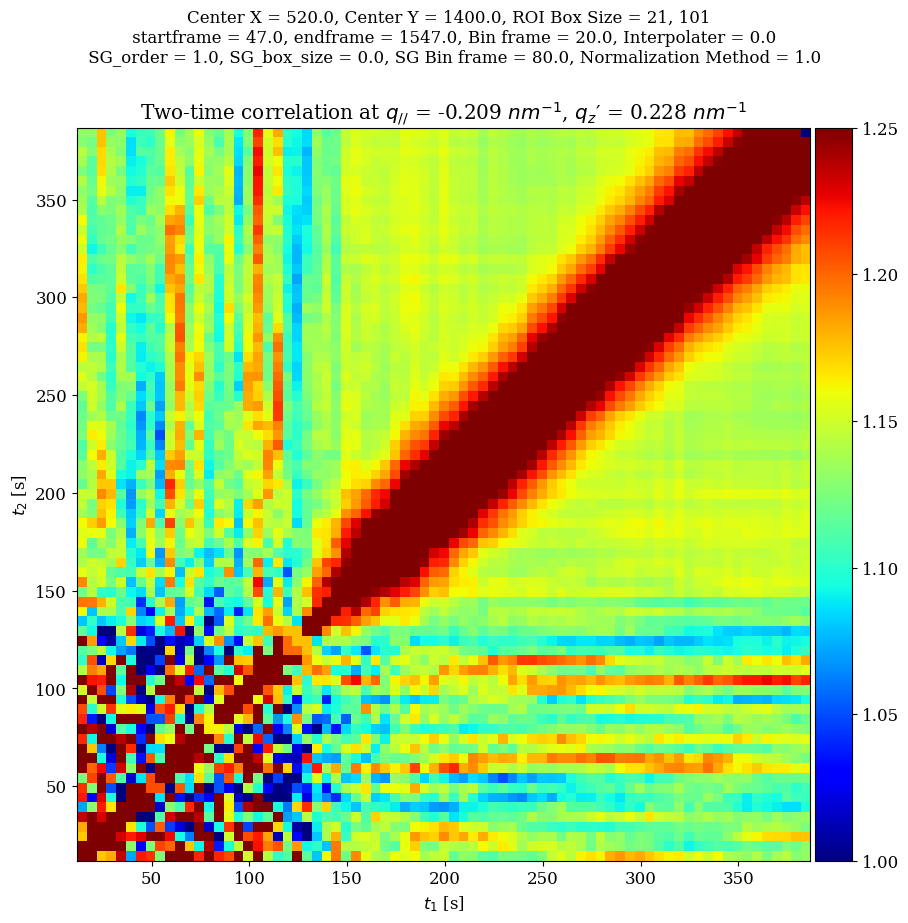

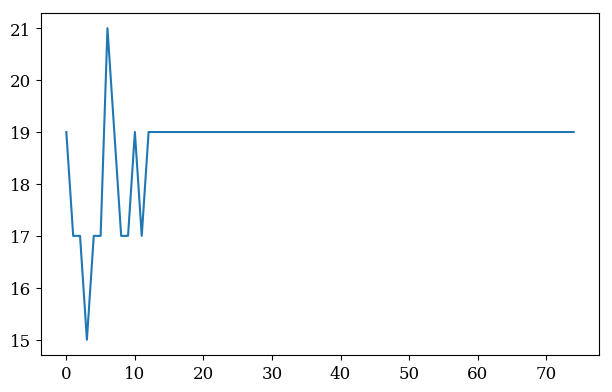

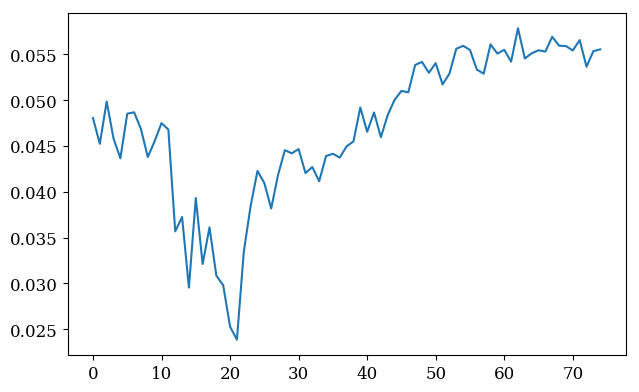

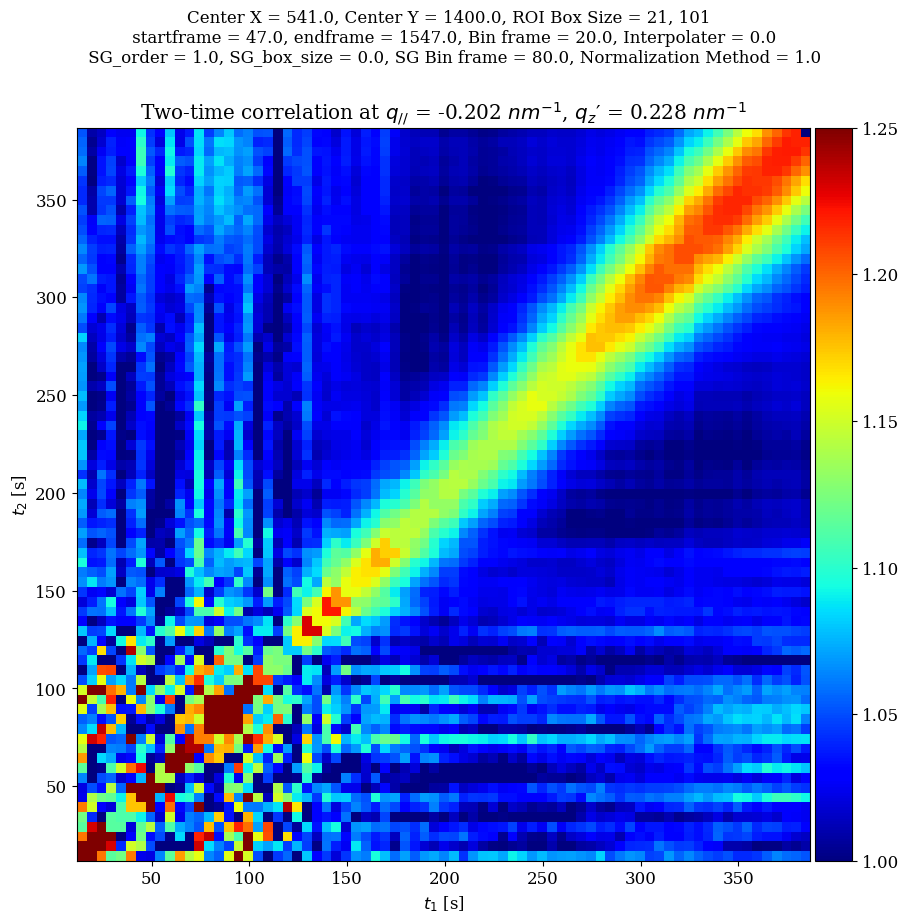

In [146]:
%run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/Dynamic_analysis_CHX.py'
from tqdm import tqdm
CenterXs,Inor_all,TTCF2, TTCFs = None, None, None, None
#7735

CenterXs,Inor_all, contrasts, Windows = collect_normalize(startframe = 47 ,endframe = 7735//5 , centerx_start = 100, centerx_end = 1300, centery = 1400,peak_in_X = 550, boxsize = (21,101), bin_frame = 20, normalize = 1, SG_window = 0, SG_order = 1,  SG_bin_frame = 80, interpolate = 0)
TTCF2, TTCFs = TTCF(CenterXs,Inor_all)
print('41 box size 40 frame bin, norm 3, 25-1SG ')
plotTTCF(TTCFs[20], color_min = 1 , color_max = 1.25, save = 0)
plt.figure()
plt.plot(Windows)
plt.show()
plt.figure()
plt.plot(contrasts)
plt.show()
plotTTCF(TTCFs[21], color_min = 1 , color_max = 1.25, save = 0)

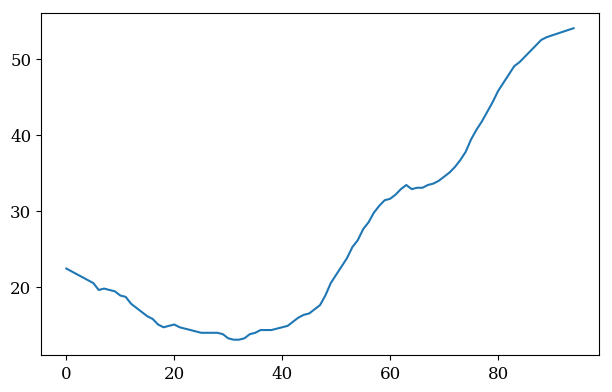

In [121]:
# sgolay2d(np.asarray(Windows), window_size=5, order=3)
from scipy import signal #.savgol_filter as sg1
a = signal.savgol_filter(Windows, window_length = 11, polyorder = 1)

plt.figure()
plt.plot(a)
plt.show()

In [122]:
a

array([22.36363636, 21.98181818, 21.6       , 21.21818182, 20.83636364,
       20.45454545, 19.54545455, 19.72727273, 19.54545455, 19.36363636,
       18.81818182, 18.63636364, 17.72727273, 17.18181818, 16.63636364,
       16.09090909, 15.72727273, 15.        , 14.63636364, 14.81818182,
       15.        , 14.63636364, 14.45454545, 14.27272727, 14.09090909,
       13.90909091, 13.90909091, 13.90909091, 13.90909091, 13.72727273,
       13.18181818, 13.        , 13.        , 13.18181818, 13.72727273,
       13.90909091, 14.27272727, 14.27272727, 14.27272727, 14.45454545,
       14.63636364, 14.81818182, 15.36363636, 15.90909091, 16.27272727,
       16.45454545, 17.        , 17.54545455, 18.81818182, 20.45454545,
       21.54545455, 22.63636364, 23.72727273, 25.18181818, 26.09090909,
       27.54545455, 28.45454545, 29.72727273, 30.63636364, 31.36363636,
       31.54545455, 32.09090909, 32.81818182, 33.36363636, 32.81818182,
       33.        , 33.        , 33.36363636, 33.54545455, 33.90

In [132]:
def round_up_to_odd(f):
    converted = np.ceil(f-1) // 2 * 2 + 1
    return converted.astype(int)
round_up_to_odd(a)

array([23, 21, 21, 21, 21, 21, 19, 19, 19, 19, 19, 19, 17, 17, 17, 17, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 15, 15, 15, 15, 15, 15, 15, 15, 17, 17, 17, 17, 19, 21, 21,
       23, 23, 25, 27, 27, 29, 29, 31, 31, 31, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 35, 35, 35, 37, 37, 39, 41, 41, 43, 45, 45, 47, 47, 49, 49,
       51, 51, 51, 53, 53, 53, 53, 53, 53, 53])

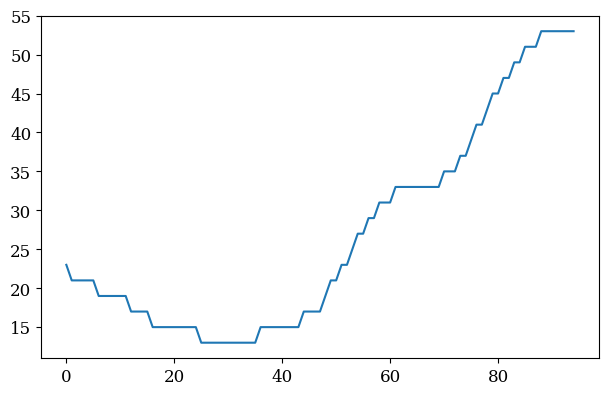

In [133]:
plt.figure()
plt.plot(round_up_to_odd(a))
plt.show()

100%|██████████| 50/50 [03:51<00:00,  4.62s/it]


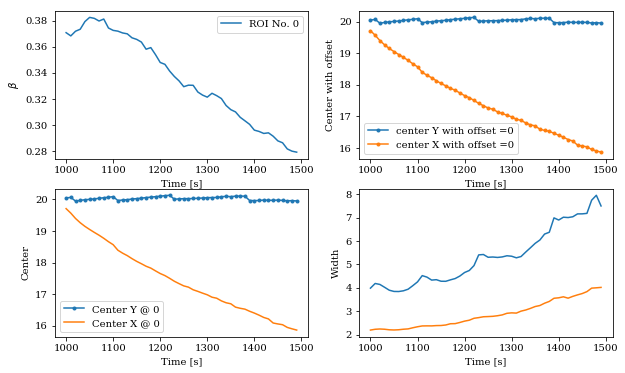

In [138]:

        
def track_speckle(startY,endY,delY,startX,endX,delX,startframe,endframe, refframe,Xlogscale= False, normalize = 1, bin_frame = 1, SG_frame = 5, SG_order = 1, SG_box_size = 23, interpolater_on = False):
    """
    will call the functions in autocor.py. make sure to run this first. the g2 calculation in here is done by the code written
    Mark Sutton. It follows the multi-tau method
    
    skip => skips the frame of interest
    bin_num and bin_skip are for normalization 
    bin_num bin over specified number of frames for normalization and bin_skip determines if you want to do binning over the bin_num frames around the next frame or skip to another one. However you bin_num or bin_skip it. the normalzation will match with the t1 or t2 you are considering. This computational structer was conceived first before TTCF binning method. 
    
    skip and bin_skip are not in sync necessarily. 
    
    comparing to TTCF terms. 
    skip --> bin_frame
    bin_num --> SG_Bin_frame
    bin_skip ---> no equivalence in TTCF codes... it lets to skip frames while binning for SG to save computation time
    
    
    star, end del X Y represent the pixel numbers usually from 0 to 2160 in 4M eiger
    start frame and end frame should be within available frame range of the data
    Xlogscale will increase delX in log scale, the increment is determined by Xlog_num
    p0 are the initial parameters for the curefit to try while fitting for the exponents
    normalizewith_Sg = 0 usues the average frame of the entire start-end frame range
    normalizewith_Sg = 1 usues SG smootheing per frame with SG-order and SG-Box_size
    normalizewith_Sg = 2 does binning frames and averaging them and using only the localized average.
    normalizewith_Sg = 3 does binning frames and averaging them and using the smoothened frame of the average.
    
    """
#     numberofframes = endframe - startframe
    
    pixellist=np.where(mask.ravel()==1)[0] #list of valid pixels
    #partition in bins using x,y (i,j) indices
    yy,xx=np.unravel_index(pixellist,mask.shape)
    
    if Xlogscale:
        ylist=mkpartlist(np.arange(startY,endY,delY)) # break points for bins in y
        xlist=mkpartlist(np.round(np.geomspace(startX,endX,Xlog_num),decimals=0).astype(int)) # break points for bins in x
#         print(xlist)
        
#         ylist=mkpartlist(np.arange(startY,endY,delY)) # break points for bins in y
#         xlist=mkpartlist(np.round(np.logspace(np.log10(startX), np.log10(endX), num=Xlog_num),decimals=0).astype(int)) # break points for bins in x
#         print(xlist)
        
    else:
        ylist=mkpartlist(np.arange(startY,endY,delY)) # break points for bins in y
        xlist=mkpartlist(np.arange(startX,endX,delX)) # break points for bins in x
    plist,bind,xbind,ybind,noperbin,inpixellist,binlist,binxlist,binylist=\
        partition2d(pixellist,xx,xlist,yy,ylist)
    
    
    if refframe !=0:
        img1=FD.rdframe(refframe-bin_frame//2) #reference (in middle)
        for i in np.arange(refframe-bin_frame//2 +1, refframe+bin_frame//2+1):
            img1 += FD.rdframe(i)
    else:
        refframe = refframe-bin_frame
        img1=FD.rdframe(refframe-bin_frame//2) #reference (in middle)
        for i in np.arange(refframe-bin_frame//2 +1, refframe+bin_frame//2+1):
            img1 += FD.rdframe(i)
    
    
    #how to look at partitions
    image = img1
    
    
    ii=-1+0*img1 #make bind==0 stand out
    ii[np.unravel_index(plist,ii.shape)]=bind
#     ii=0*image
#     ii[np.unravel_index(plist,ii.shape)]=bind+1 #bind==0 is not a bin
    # Choose images to test correlations on.
    img1=image
    img0 = image*ii
    
    ii=-1+0*img1 #make bind==0 stand out
    ii[np.unravel_index(plist,ii.shape)]=bind
    
    beg=startframe
    no=endframe-startframe+1
    
    
    
    res2=np.zeros((1,(no-1)//bin_frame,5)) #len(rr)
    CC = crosscor(img1.shape,mask=ii+1,normalization="symavg")

    for imgno in tqdm(np.arange(beg,beg+no-1,bin_frame)):
        if refframe == 0:
            img1=None
            img1=FD.rdframe(refframe-bin_frame//2) #reference (in middle)
            for i in np.arange(refframe-bin_frame//2 +1, refframe+bin_frame//2+1):
                img1 += FD.rdframe(i)
            refframe += bin_frame
        img2=FD.rdframe(imgno-bin_frame//2) #reference (in middle)
        for i in np.arange(imgno-bin_frame//2 +1, imgno+bin_frame//2+1):
            img2 += FD.rdframe(i)
            
    #     cx=a[p[0],p[1]]-ax*dx*dx
        rr=CC(img1,img2)
#         print(np.shape(rr))
        for j in range(1):#len(rr)
            try:
                a=rr#[j]
    #             p=r_[5,5]+np.unravel_index(np.argmax(a[5:-5,5:-5], axis=None), (10,10))
                p=np.unravel_index(np.argmax(a, axis=None), a.shape) #position of max
    #             print(a.shape)
                ax=(a[p[0]-1,p[1]]+a[p[0]+1,p[1]]-2*a[p[0],p[1]])/2.
                dx=(a[p[0]-1,p[1]]-a[p[0]+1,p[1]])/4./ax
                ay=(a[p[0],p[1]-1]+a[p[0],p[1]+1]-2*a[p[0],p[1]])/2.
                dy=(a[p[0],p[1]-1]-a[p[0],p[1]+1])/4./ay
                cy=a[p[0],p[1]]-ay*dy*dy
                cx=a[p[0],p[1]]-ax*dx*dx
                res2[j,(imgno-beg)//bin_frame,:]=r_[(cx+cy)/2.,p[0]+dx,p[1]+dy,np.sqrt(-cx/2/ax),np.sqrt(-cy/2/ay)]
            except:
                pass
    
    
    #plot results beta,px,py,sx,sy
    time = np.arange(startframe,endframe,bin_frame)*datatakingtime
    fig,((ax0,ax1),(ax2,ax3))=plt.subplots(2,2,figsize=(10,6))
    for j in range(1):#len(rr)
        ax0.plot(time,res2[j,:,0]-1.0,label="ROI No. %d"%j)#beta
        ax0.set_xlabel('Time [s]')
        ax0.set_ylabel(r'$\beta$')

        ax2.plot(time,res2[j,:,2],'.-',label="Center Y @ %d"%j)#center x
        ax2.set_xlabel('Time [s]')
        ax2.set_ylabel('Center')

        ax3.plot(time, res2[j,:,3]+j,label="Width Y with offset @ %d"%j)#width x
        ax3.set_xlabel('Time [s]')
        ax3.set_ylabel('Width')

        ax2.plot(time,res2[j,:,1],label="Center X @ %d"%j)#center y


        ax3.plot(time,res2[j,:,4]+j,label="Witdh X with offset @ %d"%j)#width y

        ax1.plot(time,res2[j,:,2]+j,'.-',label="center Y with offset =%d"%j) #center x with offset
        ax1.plot(time,res2[j,:,1]+j,'.-',label="center X with offset =%d"%j) #center y with offset
        ax1.set_xlabel('Time [s]')
        ax1.set_ylabel('Center with offset')

        ax0.legend(loc='best')
        ax1.legend(loc='best')
        ax2.legend(loc='best')
        
%matplotlib inline
%matplotlib inline

track_speckle(startY = 1250,endY = 1291,delY = 40,startX = 440,endX = 481,delX= 40,startframe=4000,endframe=6000, refframe=3900,Xlogscale= False, normalize = 1, bin_frame = 40, SG_frame = 5, SG_order = 1, SG_box_size = 23, interpolater_on = False)


100%|██████████| 50/50 [03:52<00:00,  4.64s/it]


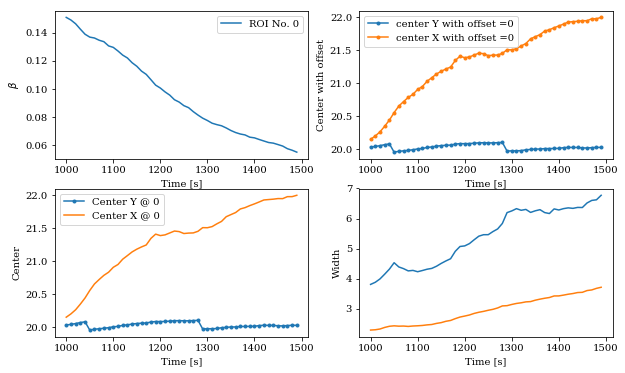

In [139]:
%run -i '/home/pmyint/analysis/2019_1/pmyint/ResPipelines/Dynamic_analysis_CHX.py'
track_speckle(startY = 1250,endY = 1291,delY = 40,startX = 1700,endX = 1741,delX= 40,startframe=4000,endframe=6000, refframe=3900,Xlogscale= False, normalize = 1, bin_frame = 40, SG_frame = 5, SG_order = 1, SG_box_size = 23, interpolater_on = False)

100%|██████████| 50/50 [02:18<00:00,  2.78s/it]


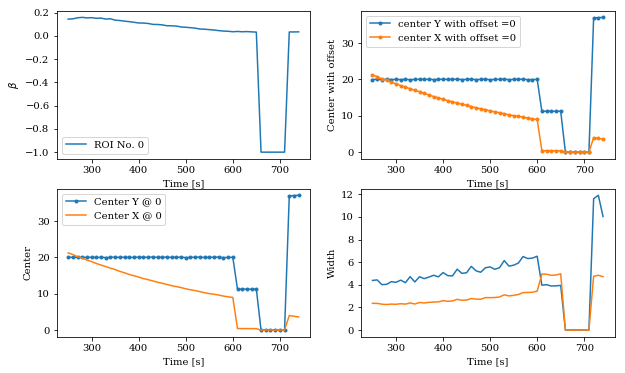

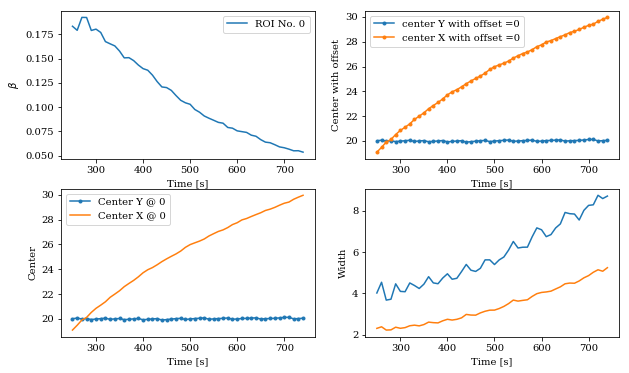

In [141]:
track_speckle(startY = 1250,endY = 1291,delY = 40,startX = 440,endX = 481,delX= 40,startframe=1000,endframe=3000, refframe=1100,Xlogscale= False, normalize = 1, bin_frame = 40, SG_frame = 5, SG_order = 1, SG_box_size = 23, interpolater_on = False)
track_speckle(startY = 1250,endY = 1291,delY = 40,startX = 1700,endX = 1741,delX= 40,startframe=1000,endframe=3000, refframe=1100,Xlogscale= False, normalize = 1, bin_frame = 40, SG_frame = 5, SG_order = 1, SG_box_size = 23, interpolater_on = False)

100%|██████████| 50/50 [03:41<00:00,  4.42s/it]


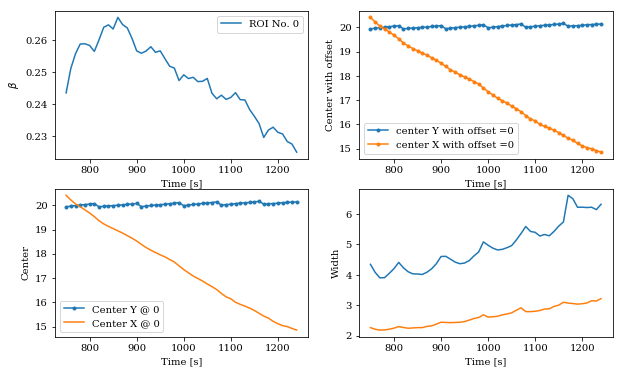

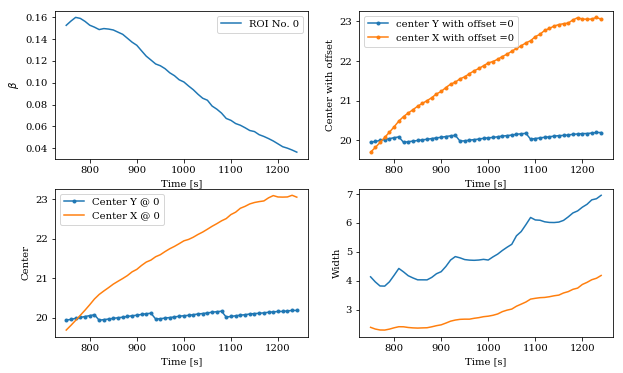

In [142]:
track_speckle(startY = 1250,endY = 1291,delY = 40,startX = 440,endX = 481,delX= 40,startframe=3000,endframe=5000, refframe=3100,Xlogscale= False, normalize = 1, bin_frame = 40, SG_frame = 5, SG_order = 1, SG_box_size = 23, interpolater_on = False)
track_speckle(startY = 1250,endY = 1291,delY = 40,startX = 1700,endX = 1741,delX= 40,startframe=3000,endframe=5000, refframe=3100,Xlogscale= False, normalize = 1, bin_frame = 40, SG_frame = 5, SG_order = 1, SG_box_size = 23, interpolater_on = False)